### 전력소비량 예측 데이터 전처리 & EDA
#### 목차
1. 데이터 로드 및 전처리 (PowerUsagePreprocessor 클래스 사용)
2. 전처리된 데이터 탐색
3. EDA (Exploratory Data Analysis)
4. 전처리된 데이터 저장 및 이상치 분석

**주요 변경사항:**
- 전처리 로직을 `PowerUsagePreprocessor` 클래스로 모듈화
- 재사용 가능한 전처리 파이프라인 구축
- 자동화된 특성 엔지니어링 (시간대, 계절, 온도 카테고리 등)

##### 1. 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config.config as cf
from preprocessing import PowerUsagePreprocessor

# 한글 폰트 설정
plt.rc("font", family = "Malgun Gothic")
sns.set_theme(font="Malgun Gothic")

# 전처리기 인스턴스 생성
preprocessor = PowerUsagePreprocessor()

# 데이터 불러오기
preprocessor.load_data()
train = preprocessor.train
test = preprocessor.test
building = preprocessor.building
sample_submission = preprocessor.sample_submission

# 데이터 확인
display(train.head())
display(test.head())
display(building.head())
display(sample_submission.head())

INFO:root:데이터 로딩 시작...
INFO:root:데이터 로딩 완료 - Train: (204000, 10), Test: (16800, 7), Sample: (16800, 2), Building: (100, 7)


num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20240601 00     1  20240601 00    18.3      0.0      2.6   82.0     0.0   
1  1_20240601 01     1  20240601 01    18.3      0.0      2.7   82.0     0.0   
2  1_20240601 02     1  20240601 02    18.1      0.0      2.6   80.0     0.0   
3  1_20240601 03     1  20240601 03    18.0      0.0      2.6   81.0     0.0   
4  1_20240601 04     1  20240601 04    17.8      0.0      1.3   81.0     0.0   

   일사(MJ/m2)  전력소비량(kWh)  
0        0.0     5794.80  
1        0.0     5591.85  
2        0.0     5338.17  
3        0.0     4554.42  
4        0.0     3602.25

num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)
0  1_20240825 00     1  20240825 00    26.5      0.0      0.7   80.0
1  1_20240825 01     1  20240825 01    26.1      0.0      0.0   80.0
2  1_20240825 02     1  20240825 02    25.9      0.0      0.3   83.0
3  1_20240825 03     1  20240825 03    25.7      0.0      1.1   83.0
4  1_20240825 04     1  20240825 04    25.5      0.0      1.0   86.0

건물번호 건물유형    연면적(m2)   냉방면적(m2) 태양광용량(kW) ESS저장용량(kWh) PCS용량(kW)
0     1   호텔   82912.71   77586.00         -            -         -
1     2   상용   40658.90   30392.82         -            -         -
2     3   병원  560431.00  418992.00    278.58            -         -
3     4   호텔   41813.29   23715.71         -            -         -
4     5   학교  403749.39  248507.00   1983.05         1025       250

num_date_time  answer
0  1_20240825 00       0
1  1_20240825 01       0
2  1_20240825 02       0
3  1_20240825 03       0
4  1_20240825 04       0

##### 2. 데이터 탐색

In [2]:
#=== Data Overview ===
print("\n칼럼명:")
print(f"train: {list(train.columns)}")
print(f"test: {list(test.columns)}")
print(f"building: {list(building.columns)}")


칼럼명:
train: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
test: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']
building: ['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']


In [3]:
def print_data_info(df):
    print(f"Shape: {df.shape}\n")
    print(f"Columns: {list(df.columns)}\n")
    print(f"Data Types:\n{df.dtypes}\n")
    print(f"Missing Values:\n{df.isnull().sum()}\n")

In [4]:
#=== 데이터 확인 ===
print_data_info(train)

Shape: (204000, 10)

Columns: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']

Data Types:
num_date_time     object
건물번호               int64
일시                object
기온(°C)           float64
강수량(mm)          float64
풍속(m/s)          float64
습도(%)            float64
일조(hr)           float64
일사(MJ/m2)        float64
전력소비량(kWh)       float64
dtype: object

Missing Values:
num_date_time    0
건물번호             0
일시               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
dtype: int64



In [5]:
print_data_info(test)

Shape: (16800, 7)

Columns: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']

Data Types:
num_date_time     object
건물번호               int64
일시                object
기온(°C)           float64
강수량(mm)          float64
풍속(m/s)          float64
습도(%)            float64
dtype: object

Missing Values:
num_date_time    0
건물번호             0
일시               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
dtype: int64



In [6]:
print_data_info(building)

Shape: (100, 7)

Columns: ['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']

Data Types:
건물번호              int64
건물유형             object
연면적(m2)         float64
냉방면적(m2)        float64
태양광용량(kW)        object
ESS저장용량(kWh)     object
PCS용량(kW)        object
dtype: object

Missing Values:
건물번호            0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
dtype: int64



##### 1) 칼럼명 변경

In [7]:
preprocessor._rename_columns()
train = preprocessor.train
test = preprocessor.test
building = preprocessor.building

print(train.columns, test.columns, building.columns)

INFO:root:컬럼명 영어 변환 중...
INFO:root:컬럼명 변환 완료


Index(['num_date_time', 'building_num', 'date_time', 'temperature', 'rain',
       'wind', 'humidity', 'sunshine_duration', 'solar_radiation',
       'power_usage'],
      dtype='object') Index(['num_date_time', 'building_num', 'date_time', 'temperature', 'rain',
       'wind', 'humidity'],
      dtype='object') Index(['building_num', 'building_type', 'floor_area', 'cool_area',
       'solar_capacity', 'ess_capacity', 'pcs_capacity'],
      dtype='object')


In [8]:
# Object 변수 고유값 확인
for col in train.select_dtypes(include=['object']).columns:
    print(f"{col} 고유값: {train[col].unique()}")

for col in building.select_dtypes(include=['object']).columns:
    print(f"{col} 고유값: {building[col].unique()}")

num_date_time 고유값: ['1_20240601 00' '1_20240601 01' '1_20240601 02' ... '100_20240824 21'
 '100_20240824 22' '100_20240824 23']
date_time 고유값: ['20240601 00' '20240601 01' '20240601 02' ... '20240824 21' '20240824 22'
 '20240824 23']
building_type 고유값: ['호텔' '상용' '병원' '학교' '건물기타' '아파트' '연구소' '백화점' 'IDC(전화국)' '공공']
solar_capacity 고유값: ['-' '278.58' '1983.05' '389.76' '217.92' '1349.03' '276' '849.78'
 '1974.71' '97' '100' '255.88' '879.82' '858.02' '953.4' '83.95' '97.85'
 '344.96' '342' '12.24' '83.2' '74.25' '140.6' '77.76' '198.56' '10.08'
 '218.88' '1039.86' '105' '215.89' '1397.02' '199.4' '219.6' '820'
 '540.57' '50.88' '94.38' '1297.98' '1340.1' '103' '419.2' '36' '790.08'
 '605' '495' '282.95' '38.88' '77.38' '168' '322.9' '99.64' '20.25'
 '81.38' '171.6']
ess_capacity 고유값: ['-' '1025' '101.5' '500' '3100' '205' '469.2' '2000' '1670' '150' '201.1'
 '209']
pcs_capacity 고유값: ['-' '250' '101' '500' '1500' '150' '1000' '550' '75' '100']


Train data의 object 변수는 num_date_time & 일시로,
전자의 경우 고유의 ID를 나타내는 것이고,
후자는 datetime 객체로 변환할 필요가 있음.

Building data에서 수치로 보여지는 값들은 모종의 이유로 측정되지 않은 값을 ('-')로 표기하기 때문에, object가 된 것.
=> '-'를 nan으로 바꾸고, float data type으로 변환할 필요 있음.

건물유형 고유값: ['호텔' '상용' '병원' '학교' '건물기타' '아파트' '연구소' '백화점' 'IDC(전화국)' '공공']

##### 2) 일시 칼럼 전처리
preprocess_datetime() 에서 아래와 같은 전처리 수행
- datetime 변환
- 월, 일, 시간 특성 추출해 칼럼 추가
- 주말/평일 칼럼, 공휴일 유무 칼럼 추가

In [9]:
display(train.head())

preprocessor.preprocess_datetime()
train = preprocessor.train
test = preprocessor.test

display(train.head())

num_date_time  building_num    date_time  temperature  rain  wind  \
0  1_20240601 00             1  20240601 00         18.3   0.0   2.6   
1  1_20240601 01             1  20240601 01         18.3   0.0   2.7   
2  1_20240601 02             1  20240601 02         18.1   0.0   2.6   
3  1_20240601 03             1  20240601 03         18.0   0.0   2.6   
4  1_20240601 04             1  20240601 04         17.8   0.0   1.3   

   humidity  sunshine_duration  solar_radiation  power_usage  
0      82.0                0.0              0.0      5794.80  
1      82.0                0.0              0.0      5591.85  
2      80.0                0.0              0.0      5338.17  
3      81.0                0.0              0.0      4554.42  
4      81.0                0.0              0.0      3602.25

INFO:root:날짜/시간 특성 추출 중...


INFO:root:제거할 컬럼: ['day_of_week']
INFO:root:지정된 컬럼 제거 완료
INFO:root:제거할 컬럼: ['day_of_week']
INFO:root:지정된 컬럼 제거 완료
INFO:root:날짜/시간 특성 추출 완료


num_date_time  building_num           date_time  temperature  rain  wind  \
0  1_20240601 00             1 2024-06-01 00:00:00         18.3   0.0   2.6   
1  1_20240601 01             1 2024-06-01 01:00:00         18.3   0.0   2.7   
2  1_20240601 02             1 2024-06-01 02:00:00         18.1   0.0   2.6   
3  1_20240601 03             1 2024-06-01 03:00:00         18.0   0.0   2.6   
4  1_20240601 04             1 2024-06-01 04:00:00         17.8   0.0   1.3   

   humidity  sunshine_duration  solar_radiation  power_usage  month  day  \
0      82.0                0.0              0.0      5794.80      6    1   
1      82.0                0.0              0.0      5591.85      6    1   
2      80.0                0.0              0.0      5338.17      6    1   
3      81.0                0.0              0.0      4554.42      6    1   
4      81.0                0.0              0.0      3602.25      6    1   

   hour day_type  is_holiday  
0     0  weekend           0  
1     1  weekend           0  
2     2  weekend           0  
3     3  weekend           0  
4     4  weekend           0

##### 3) 건물 정보 전처리

In [10]:
preprocessor.preprocess_building_info()
building = preprocessor.building
print(building.isnull().sum())

INFO:root:건물 정보 전처리 중...
INFO:root:건물 정보 - 태양광, ESS, PCS 용량 데이터 수치 데이터로 변경 완료: 


building_num       0
building_type      0
floor_area         0
cool_area          0
solar_capacity    47
ess_capacity      88
pcs_capacity      88
dtype: int64


In [11]:
building[building['solar_capacity'].isnull()] # 태양광이 없는 건물은 ESS와 PCS도 없는 것으로 보임

building_num building_type   floor_area    cool_area  solar_capacity  \
0              1            호텔    82912.710    77586.000             NaN   
1              2            상용    40658.900    30392.820             NaN   
3              4            호텔    41813.290    23715.710             NaN   
5              6            상용   157835.000   157835.000             NaN   
8              9            호텔   136757.000   109024.000             NaN   
9             10            호텔   435993.500   341983.000             NaN   
10            11           아파트   271233.000   233263.000             NaN   
15            16            상용    47999.000    28795.000             NaN   
16            17            병원    82573.610    68513.410             NaN   
17            18           백화점    51123.000    21751.000             NaN   
24            25           아파트   340630.000   247380.000             NaN   
26            27           백화점    66106.020    40000.000             NaN   
27            28            호텔    43894.830     5619.700             NaN   
29            30      IDC(전화국)    31156.750    13487.000             NaN   
30            31           아파트   186132.260   122153.000             NaN   
31            32           백화점    77917.000    35676.000             NaN   
34            35      IDC(전화국)    27966.920    20397.000             NaN   
35            36      IDC(전화국)    32558.000    16873.000             NaN   
39            40           백화점    57684.930    15770.320             NaN   
40            41            상용    10064.000     1862.000             NaN   
44            45           백화점   196028.200    74378.250             NaN   
45            46            학교   141963.910   135526.790             NaN   
46            47          건물기타    80337.000    66947.000             NaN   
50            51            상용    18501.000    10466.000             NaN   
53            54           백화점   133899.430    66658.000             NaN   
55            56            상용    10035.420     7593.530             NaN   
57            58          건물기타    95625.000    54824.000             NaN   
58            59           백화점   169052.000    33867.000             NaN   
60            61          건물기타    45370.540    18125.000             NaN   
61            62           연구소    66240.000    31867.000             NaN   
62            63           백화점    51771.620    12066.860             NaN   
64            65           아파트   300496.816   183315.469             NaN   
69            70           아파트   492485.514   415124.587             NaN   
70            71           아파트   228427.470   131500.000             NaN   
73            74           백화점   146518.000    98493.000             NaN   
76            77            호텔    79953.780    58489.310             NaN   
77            78          건물기타   194433.000    10435.000             NaN   
78            79           백화점   338093.000   130928.200             NaN   
80            81      IDC(전화국)    36142.330      337.840             NaN   
81            82          건물기타    83948.469    46397.000             NaN   
83            84            호텔    95232.880    23603.000             NaN   
84            85           아파트   252313.000   252257.000             NaN   
90            91           아파트   364652.770   243493.983             NaN   
92            93           아파트   308165.640    22210.390             NaN   
95            96          건물기타  3260213.410  1956128.000             NaN   
97            98            호텔    99102.620    22097.000             NaN   
99           100            호텔   162070.240   152943.000             NaN   

    ess_capacity  pcs_capacity  
0            NaN           NaN  
1            NaN           NaN  
3            NaN           NaN  
5            NaN           NaN  
8            NaN           NaN  
9            NaN           NaN  
10           NaN           NaN  
15           NaN           NaN  
16           NaN           NaN  
17           NaN         

In [12]:
building[(building['ess_capacity'].isnull()) & (building['pcs_capacity'].isnull())] # ESS가 있으면서 PCS가 없는 건물은 없음 (vice versa)

building_num building_type  floor_area   cool_area  solar_capacity  \
0              1            호텔    82912.71    77586.00             NaN   
1              2            상용    40658.90    30392.82             NaN   
2              3            병원   560431.00   418992.00          278.58   
3              4            호텔    41813.29    23715.71             NaN   
5              6            상용   157835.00   157835.00             NaN   
..           ...           ...         ...         ...             ...   
95            96          건물기타  3260213.41  1956128.00             NaN   
96            97          건물기타    42370.93     3975.52           81.38   
97            98            호텔    99102.62    22097.00             NaN   
98            99            상용   329867.95    13442.35          171.60   
99           100            호텔   162070.24   152943.00             NaN   

    ess_capacity  pcs_capacity  
0            NaN           NaN  
1            NaN           NaN  
2            NaN           NaN  
3            NaN           NaN  
5            NaN           NaN  
..           ...           ...  
95           NaN           NaN  
96           NaN           NaN  
97           NaN           NaN  
98           NaN           NaN  
99           NaN           NaN  

[88 rows x 7 columns]

In [13]:
# 태양광, ESS, PCS 칼럼별로 결측치 비율을 확인해보자
solar_null_ratio = building['solar_capacity'].isnull().mean()
ess_null_ratio = building['ess_capacity'].isnull().mean()
pcs_null_ratio = building['pcs_capacity'].isnull().mean()

print(f"태양광 결측치 비율: {solar_null_ratio:.2%}")
print(f"ESS 결측치 비율: {ess_null_ratio:.2%}")
print(f"PCS 결측치 비율: {pcs_null_ratio:.2%}")

태양광 결측치 비율: 47.00%
ESS 결측치 비율: 88.00%
PCS 결측치 비율: 88.00%


1. 태양광 결측치 비율은 50% 언더로, 어떻게 보면 태양광 설치 유무로 칼럼을 추가할 수 있을 듯 보인다.
2. ESS와 PCS는 결측치 비율이 동일 -> 2가지 에너지 설비가 모두 있거나, 모두 없거나임. 즉 이것도 하나로 묶어서 설비 유무로 봐도 될듯?

In [14]:
# 태양광, ESS, PCS 설치 여부를 나타내는 새로운 칼럼 추가
columns_to_add = {
    'has_solar': building['solar_capacity'].notnull().astype(int),
    'has_ess': building['ess_capacity'].notnull().astype(int),
    'has_pcs': building['pcs_capacity'].notnull().astype(int)
    }

preprocessor.add_columns('building', columns_to_add) # building 데이터에 새로운 칼럼 추가

INFO:root:building에 추가할 컬럼: ['has_solar', 'has_ess', 'has_pcs']
INFO:root:'has_solar' 칼럼이 추가되었습니다.
INFO:root:'has_ess' 칼럼이 추가되었습니다.
INFO:root:'has_pcs' 칼럼이 추가되었습니다.


   building_num building_type  floor_area  cool_area  solar_capacity  \
0             1            호텔    82912.71   77586.00             NaN   
1             2            상용    40658.90   30392.82             NaN   
2             3            병원   560431.00  418992.00          278.58   
3             4            호텔    41813.29   23715.71             NaN   
4             5            학교   403749.39  248507.00         1983.05   

   ess_capacity  pcs_capacity  has_solar  
0           NaN           NaN          0  
1           NaN           NaN          0  
2           NaN           NaN          1  
3           NaN           NaN          0  
4        1025.0         250.0          1  
   building_num building_type  floor_area  cool_area  solar_capacity  \
0             1            호텔    82912.71   77586.00             NaN   
1             2            상용    40658.90   30392.82             NaN   
2             3            병원   560431.00  418992.00          278.58   
3             4      

In [15]:
# 결측치 처리 방법 정의
strategy = {
    'solar_capacity': 'zero',  # 태양광이 없는 건물은 0으로 처리
    'ess_capacity': 'zero',    # ESS가 없는 건물은 0으로 처리
    'pcs_capacity': 'zero'     # PCS가 없는 건물은 0으로 처리
}
        
preprocessor.handle_missing_values(target_df='building', strategy=strategy)
building = preprocessor.building

INFO:root:결측값 처리 중...
d:\2025\데이터분석\Power_Usage_Analysis\preprocessing.py:199: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
INFO:root:컬럼 'solar_capacity'의 결측값 47개를 'zero' 방식으로 처리했습니다.
INFO:root:컬럼 'ess_capacity'의 결측값 88개를 'zero' 방식으로 처리했습니다.
INFO:root:컬럼 'pcs_capacity'의 결측값 88개를 'zero' 방식으로 처리했습니다.
INFO:root:결측값 처리 완료


In [16]:
building.head()

building_num building_type  floor_area  cool_area  solar_capacity  \
0             1            호텔    82912.71   77586.00            0.00   
1             2            상용    40658.90   30392.82            0.00   
2             3            병원   560431.00  418992.00          278.58   
3             4            호텔    41813.29   23715.71            0.00   
4             5            학교   403749.39  248507.00         1983.05   

   ess_capacity  pcs_capacity  has_solar  has_ess  has_pcs  
0           0.0           0.0          0        0        0  
1           0.0           0.0          0        0        0  
2           0.0           0.0          1        0        0  
3           0.0           0.0          0        0        0  
4        1025.0         250.0          1        1        1

In [17]:
# 전처리된 데이터 미리보기
print("=== 전처리된 Train Data 미리보기 ===")
display(train.head())
print("\n=== 전처리된 Test Data 미리보기 ===") 
display(test.head())
print("\n=== 전처리된 Building Data 미리보기 ===")
display(building.head())

=== 전처리된 Train Data 미리보기 ===


num_date_time  building_num           date_time  temperature  rain  wind  \
0  1_20240601 00             1 2024-06-01 00:00:00         18.3   0.0   2.6   
1  1_20240601 01             1 2024-06-01 01:00:00         18.3   0.0   2.7   
2  1_20240601 02             1 2024-06-01 02:00:00         18.1   0.0   2.6   
3  1_20240601 03             1 2024-06-01 03:00:00         18.0   0.0   2.6   
4  1_20240601 04             1 2024-06-01 04:00:00         17.8   0.0   1.3   

   humidity  sunshine_duration  solar_radiation  power_usage  month  day  \
0      82.0                0.0              0.0      5794.80      6    1   
1      82.0                0.0              0.0      5591.85      6    1   
2      80.0                0.0              0.0      5338.17      6    1   
3      81.0                0.0              0.0      4554.42      6    1   
4      81.0                0.0              0.0      3602.25      6    1   

   hour day_type  is_holiday  
0     0  weekend           0  
1     1  weekend           0  
2     2  weekend           0  
3     3  weekend           0  
4     4  weekend           0


=== 전처리된 Test Data 미리보기 ===


num_date_time  building_num           date_time  temperature  rain  wind  \
0  1_20240825 00             1 2024-08-25 00:00:00         26.5   0.0   0.7   
1  1_20240825 01             1 2024-08-25 01:00:00         26.1   0.0   0.0   
2  1_20240825 02             1 2024-08-25 02:00:00         25.9   0.0   0.3   
3  1_20240825 03             1 2024-08-25 03:00:00         25.7   0.0   1.1   
4  1_20240825 04             1 2024-08-25 04:00:00         25.5   0.0   1.0   

   humidity  month  day  hour day_type  is_holiday  
0      80.0      8   25     0  weekend           0  
1      80.0      8   25     1  weekend           0  
2      83.0      8   25     2  weekend           0  
3      83.0      8   25     3  weekend           0  
4      86.0      8   25     4  weekend           0


=== 전처리된 Building Data 미리보기 ===


building_num building_type  floor_area  cool_area  solar_capacity  \
0             1            호텔    82912.71   77586.00            0.00   
1             2            상용    40658.90   30392.82            0.00   
2             3            병원   560431.00  418992.00          278.58   
3             4            호텔    41813.29   23715.71            0.00   
4             5            학교   403749.39  248507.00         1983.05   

   ess_capacity  pcs_capacity  has_solar  has_ess  has_pcs  
0           0.0           0.0          0        0        0  
1           0.0           0.0          0        0        0  
2           0.0           0.0          1        0        0  
3           0.0           0.0          0        0        0  
4        1025.0         250.0          1        1        1

##### 4) 데이터 병합

In [18]:
preprocessor.merge_data()

train = preprocessor.train
test = preprocessor.test

INFO:root:데이터 병합 중...
INFO:root:데이터 병합 완료


##### 3. EDA (Exploratory Data Analysis)

예측 변수의 분포 파악

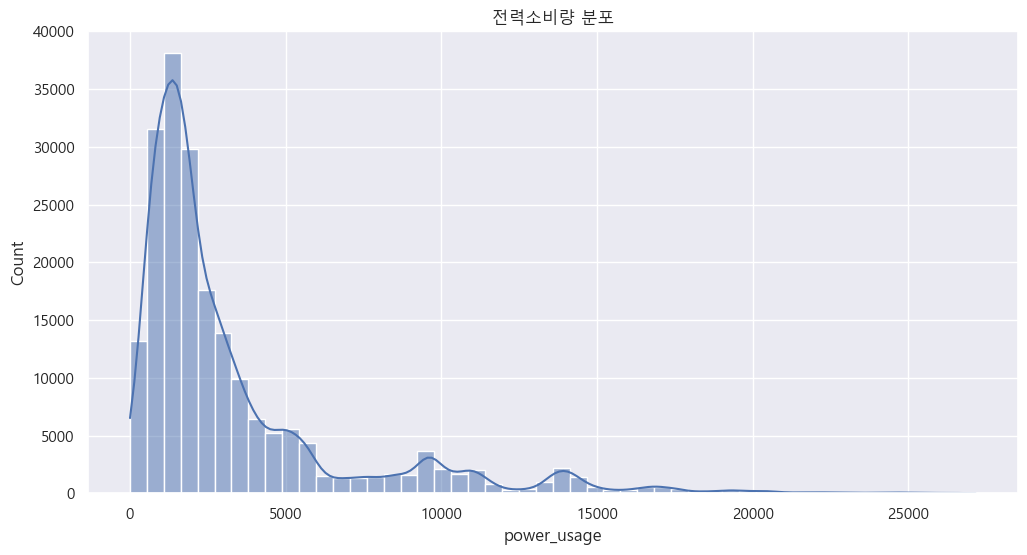

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=train, x='power_usage', bins=50, kde=True, ax=ax)
ax.set_title('전력소비량 분포')
ax.set_xlabel('power_usage')
plt.grid(True)
plt.show()

In [78]:
# 왜곡 확인
skewness = train['power_usage'].skew()
print(f"power_usage 왜곡도: {skewness:.2f}")

power_usage 왜곡도: 2.32


1. 시간대 관련 가설
- 시간대별로 전력소비량은 유의하게 다를 것이다.(예: 오후 2~5시 피크 가능성)
- 주말과 평일의 전력소비량 패턴은 다를 것이다. (건물마다 다를 수도)
- 공휴일에는 전력소비량이 낮을 것이다.
- 야간(18시~06시)에는 소비량이 낮을 것이다.


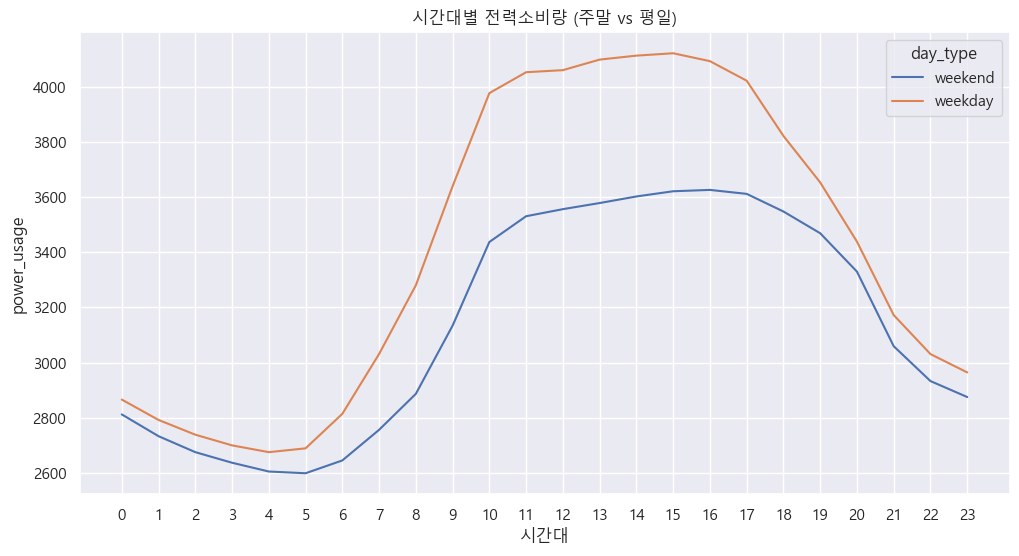

In [79]:
# 시간대별 전력소비량
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=train, x='hour', y='power_usage', hue='day_type', errorbar=None, ax=ax)
ax.set_title('시간대별 전력소비량 (주말 vs 평일)')
ax.set_xlabel('시간대')
ax.set_ylabel('power_usage')
plt.xticks(range(0, 24))  # 시간대는 0~23
plt.grid(True)
plt.show()

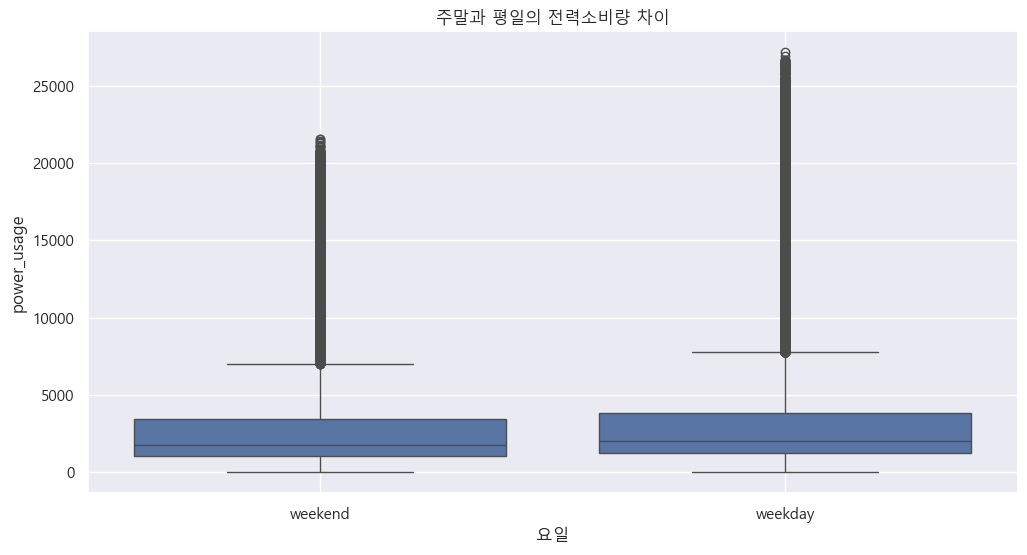

In [80]:
# 주말과 평일의 전력소비량 차이
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=train, x='day_type', y='power_usage', ax=ax)
ax.set_title('주말과 평일의 전력소비량 차이')
ax.set_xlabel('요일')
ax.set_ylabel('power_usage')
plt.grid(True)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\wldlsyy34\AppData\Local\Temp\ipykernel_26652\3342949586.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['공휴일 X', '공휴일'])


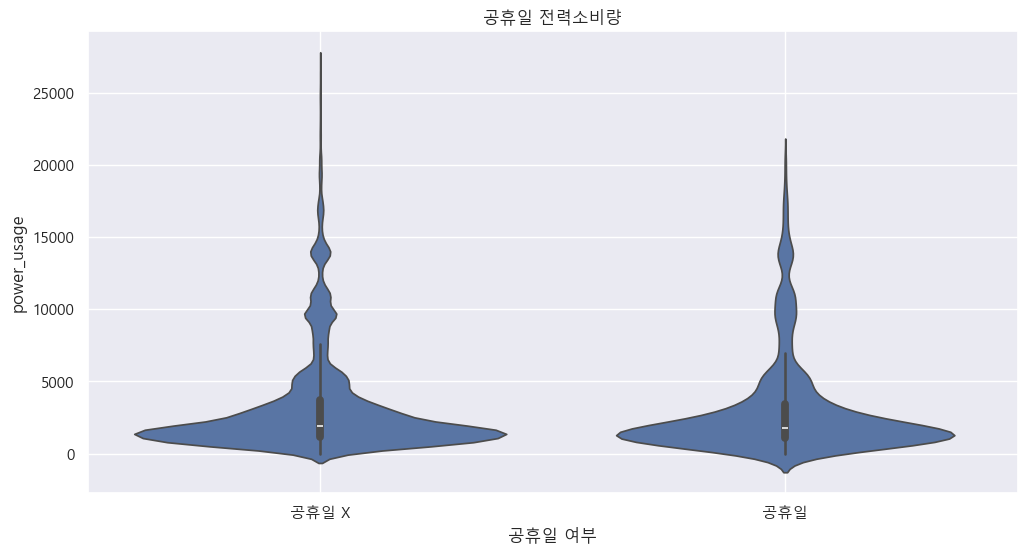

In [81]:
# 공휴일 전력소비량
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=train, x='is_holiday', y='power_usage', ax=ax)
ax.set_title('공휴일 전력소비량')
ax.set_xlabel('공휴일 여부')
ax.set_xticklabels(['공휴일 X', '공휴일'])
ax.set_ylabel('power_usage')
plt.grid(True)  
plt.show()

2. 기상 변수 관련 가설
- 기온이 높을수록 냉방 수요로 전력소비량이 증가할 것이다.
- 일사량이 높을수록 건물 내 열 축적이 커져 냉방 수요가 증가할 것이다.
- 습도가 높으면 불쾌지수 증가로 냉방 사용이 증가할 것이다.
- 풍속이 낮고 무풍상태일 경우, 열이 정체되어 냉방 수요 증가 가능성
- 비가 오는 날은 일조/일사량이 낮고 전력소비량도 낮을 것이다.

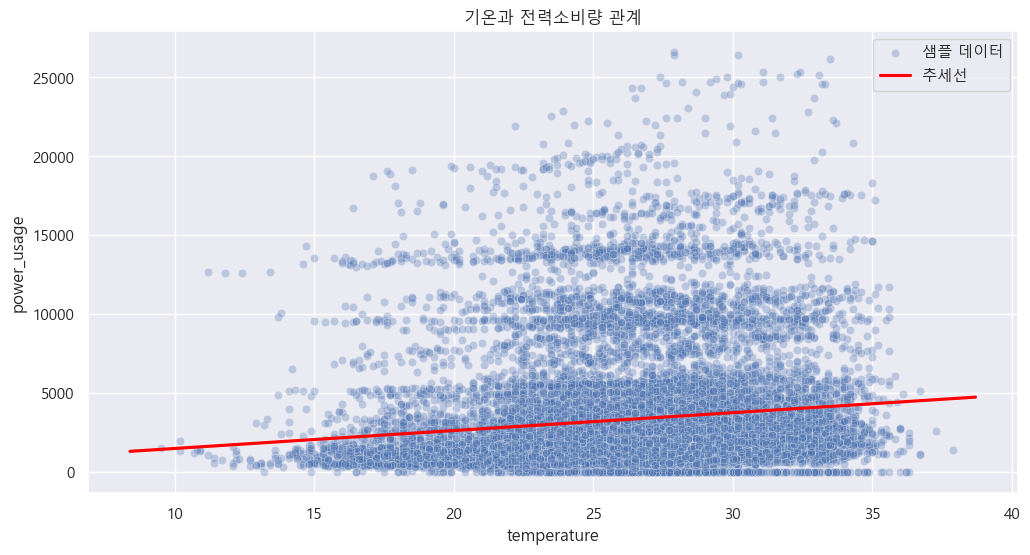

In [82]:
# 기상변수: 기온, 강수량, 풍속, 습도, 일조, 일사
# 기온과 전력소비량 관계
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train.sample(20000),  # 샘플링으로 점 개수 줄임 (전체 데이터의 약 10%)
                x='temperature', y='power_usage', alpha=0.3, label='샘플 데이터')
sns.regplot(data=train, x='temperature', y='power_usage', 
            scatter=False, color='red', label='추세선')  # 추세선만 그리기
plt.title('기온과 전력소비량 관계')
plt.xlabel('temperature')
plt.ylabel('power_usage')
plt.grid(True)
plt.legend()
plt.show()

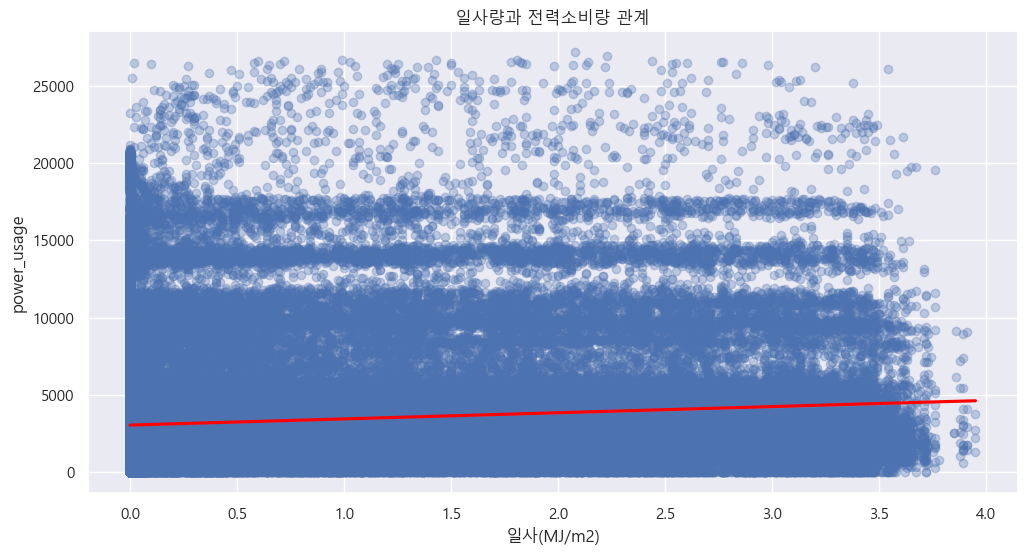

In [83]:
# 일사량과 전력소비량 관계
plt.figure(figsize=(12, 6))
sns.regplot(data=train, x='solar_radiation', y='power_usage',
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('일사량과 전력소비량 관계')
plt.xlabel('일사(MJ/m2)')
plt.ylabel('power_usage')
plt.grid(True)
plt.show()

c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


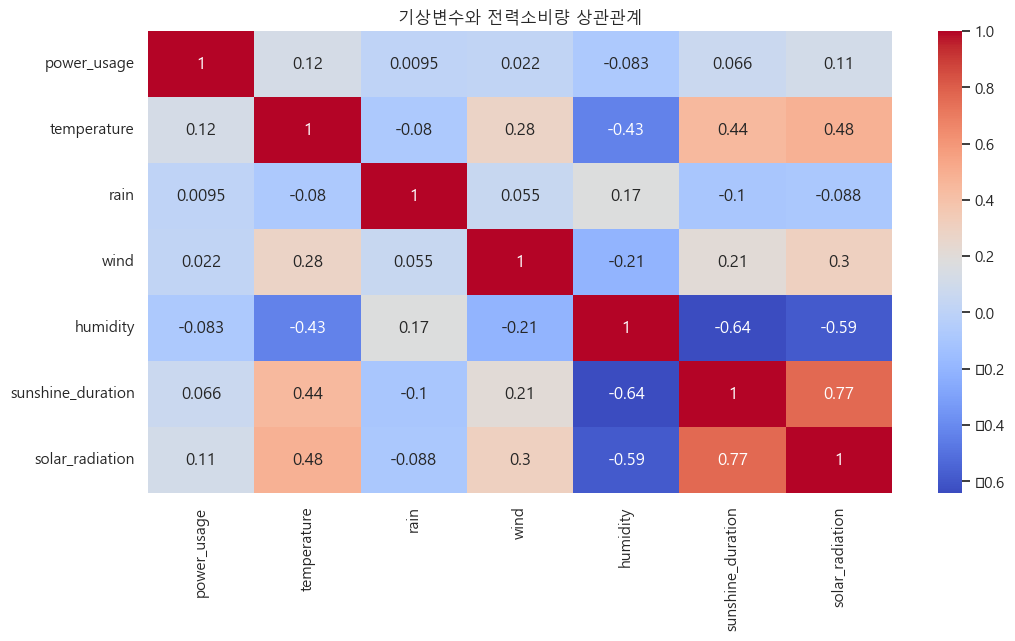

In [84]:
# 흠냐.. 기상변수와 전력소비량 전반적인 상관관계를 보자.
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(train[['power_usage', 'temperature', 'rain', 'wind', 
                   'humidity', 'sunshine_duration', 'solar_radiation']].corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('기상변수와 전력소비량 상관관계')
plt.show()

어라라ㅏ.. 생각보다 관계가 없잖아????
건물정보가 주어진거 보면.. 건물의 특성?에 따라 사용량이 달라질듯

3. 건물 속성 관련 가설
- 건물유형에 따라 전력 소비 패턴이 다를 것이다 (다중이용시설 vs 아파트)
- 연면적이 클수록 전력소비량이 클 것이다.
- 냉방면적이 클수록 여름철 전력소비량이 증가할 것이다.
- 태양광 설비가 있는 건물은 낮 시간대 소비량이 낮을 것이다.
- ESS가 있는 건물은 피크 시간대(14~17시) 전력소비량이 완화될 것이다.
- PCS 용량이 클수록 부하를 분산할 수 있어 전력소비량 변동이 적을 것이다.

In [85]:
train['building_type'].value_counts()

building_type
백화점         32640
호텔          20400
상용          20400
학교          20400
건물기타        20400
병원          18360
아파트         18360
연구소         18360
IDC(전화국)    18360
공공          16320
Name: count, dtype: int64


호텔 건물유형:
  태양광용량 고유값: [np.float64(0.0), np.float64(77.38)]
  ESS용량 고유값: [np.float64(0.0)]
  PCS용량 고유값: [np.float64(0.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity']

상용 건물유형:
  태양광용량 고유값: [np.float64(0.0), np.float64(36.0), np.float64(100.0), np.float64(171.6), np.float64(495.0)]
  ESS용량 고유값: [np.float64(0.0)]
  PCS용량 고유값: [np.float64(0.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()



병원 건물유형:
  태양광용량 고유값: [np.float64(0.0), np.float64(10.08), np.float64(74.25), np.float64(140.6), np.float64(168.0), np.float64(198.56), np.float64(255.88), np.float64(278.58), np.float64(419.2)]
  ESS용량 고유값: [np.float64(0.0), np.float64(150.0), np.float64(469.2)]
  PCS용량 고유값: [np.float64(0.0), np.float64(75.0), np.float64(150.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity', 'ess_capacity', 'pcs_capacity']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()



학교 건물유형:
  태양광용량 고유값: [np.float64(0.0), np.float64(217.92), np.float64(219.6), np.float64(282.95), np.float64(849.78), np.float64(879.82), np.float64(953.4), np.float64(1349.03), np.float64(1397.02), np.float64(1983.05)]
  ESS용량 고유값: [np.float64(0.0), np.float64(101.5), np.float64(1025.0), np.float64(2000.0)]
  PCS용량 고유값: [np.float64(0.0), np.float64(101.0), np.float64(250.0), np.float64(1000.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity', 'ess_capacity', 'pcs_capacity']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()



건물기타 건물유형:
  태양광용량 고유값: [np.float64(0.0), np.float64(81.38), np.float64(83.95), np.float64(389.76), np.float64(1297.98)]
  ESS용량 고유값: [np.float64(0.0), np.float64(1670.0)]
  PCS용량 고유값: [np.float64(0.0), np.float64(550.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity', 'ess_capacity', 'pcs_capacity']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()



아파트 건물유형:
  태양광용량 고유값: [np.float64(0.0)]
  ESS용량 고유값: [np.float64(0.0)]
  PCS용량 고유값: [np.float64(0.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()



연구소 건물유형:
  태양광용량 고유값: [np.float64(0.0), np.float64(12.24), np.float64(99.64), np.float64(215.89), np.float64(218.88), np.float64(276.0), np.float64(605.0), np.float64(858.02), np.float64(1974.71)]
  ESS용량 고유값: [np.float64(0.0), np.float64(500.0), np.float64(3100.0)]
  PCS용량 고유값: [np.float64(0.0), np.float64(500.0), np.float64(1500.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity', 'ess_capacity', 'pcs_capacity']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()



백화점 건물유형:
  태양광용량 고유값: [np.float64(0.0), np.float64(20.25), np.float64(38.88), np.float64(97.0), np.float64(97.85), np.float64(103.0), np.float64(342.0)]
  ESS용량 고유값: [np.float64(0.0), np.float64(205.0)]
  PCS용량 고유값: [np.float64(0.0), np.float64(500.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity', 'ess_capacity', 'pcs_capacity']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()



IDC(전화국) 건물유형:
  태양광용량 고유값: [np.float64(0.0), np.float64(50.88), np.float64(77.76), np.float64(105.0), np.float64(199.4), np.float64(820.0)]
  ESS용량 고유값: [np.float64(0.0)]
  PCS용량 고유값: [np.float64(0.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()



공공 건물유형:
  태양광용량 고유값: [np.float64(83.2), np.float64(94.38), np.float64(322.9), np.float64(344.96), np.float64(540.57), np.float64(790.08), np.float64(1039.86), np.float64(1340.1)]
  ESS용량 고유값: [np.float64(0.0), np.float64(201.1), np.float64(209.0), np.float64(2000.0)]
  PCS용량 고유값: [np.float64(0.0), np.float64(100.0), np.float64(101.0), np.float64(1000.0)]
  히트맵에 사용된 컬럼: ['power_usage', 'floor_area', 'cool_area', 'solar_capacity', 'ess_capacity', 'pcs_capacity']


c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


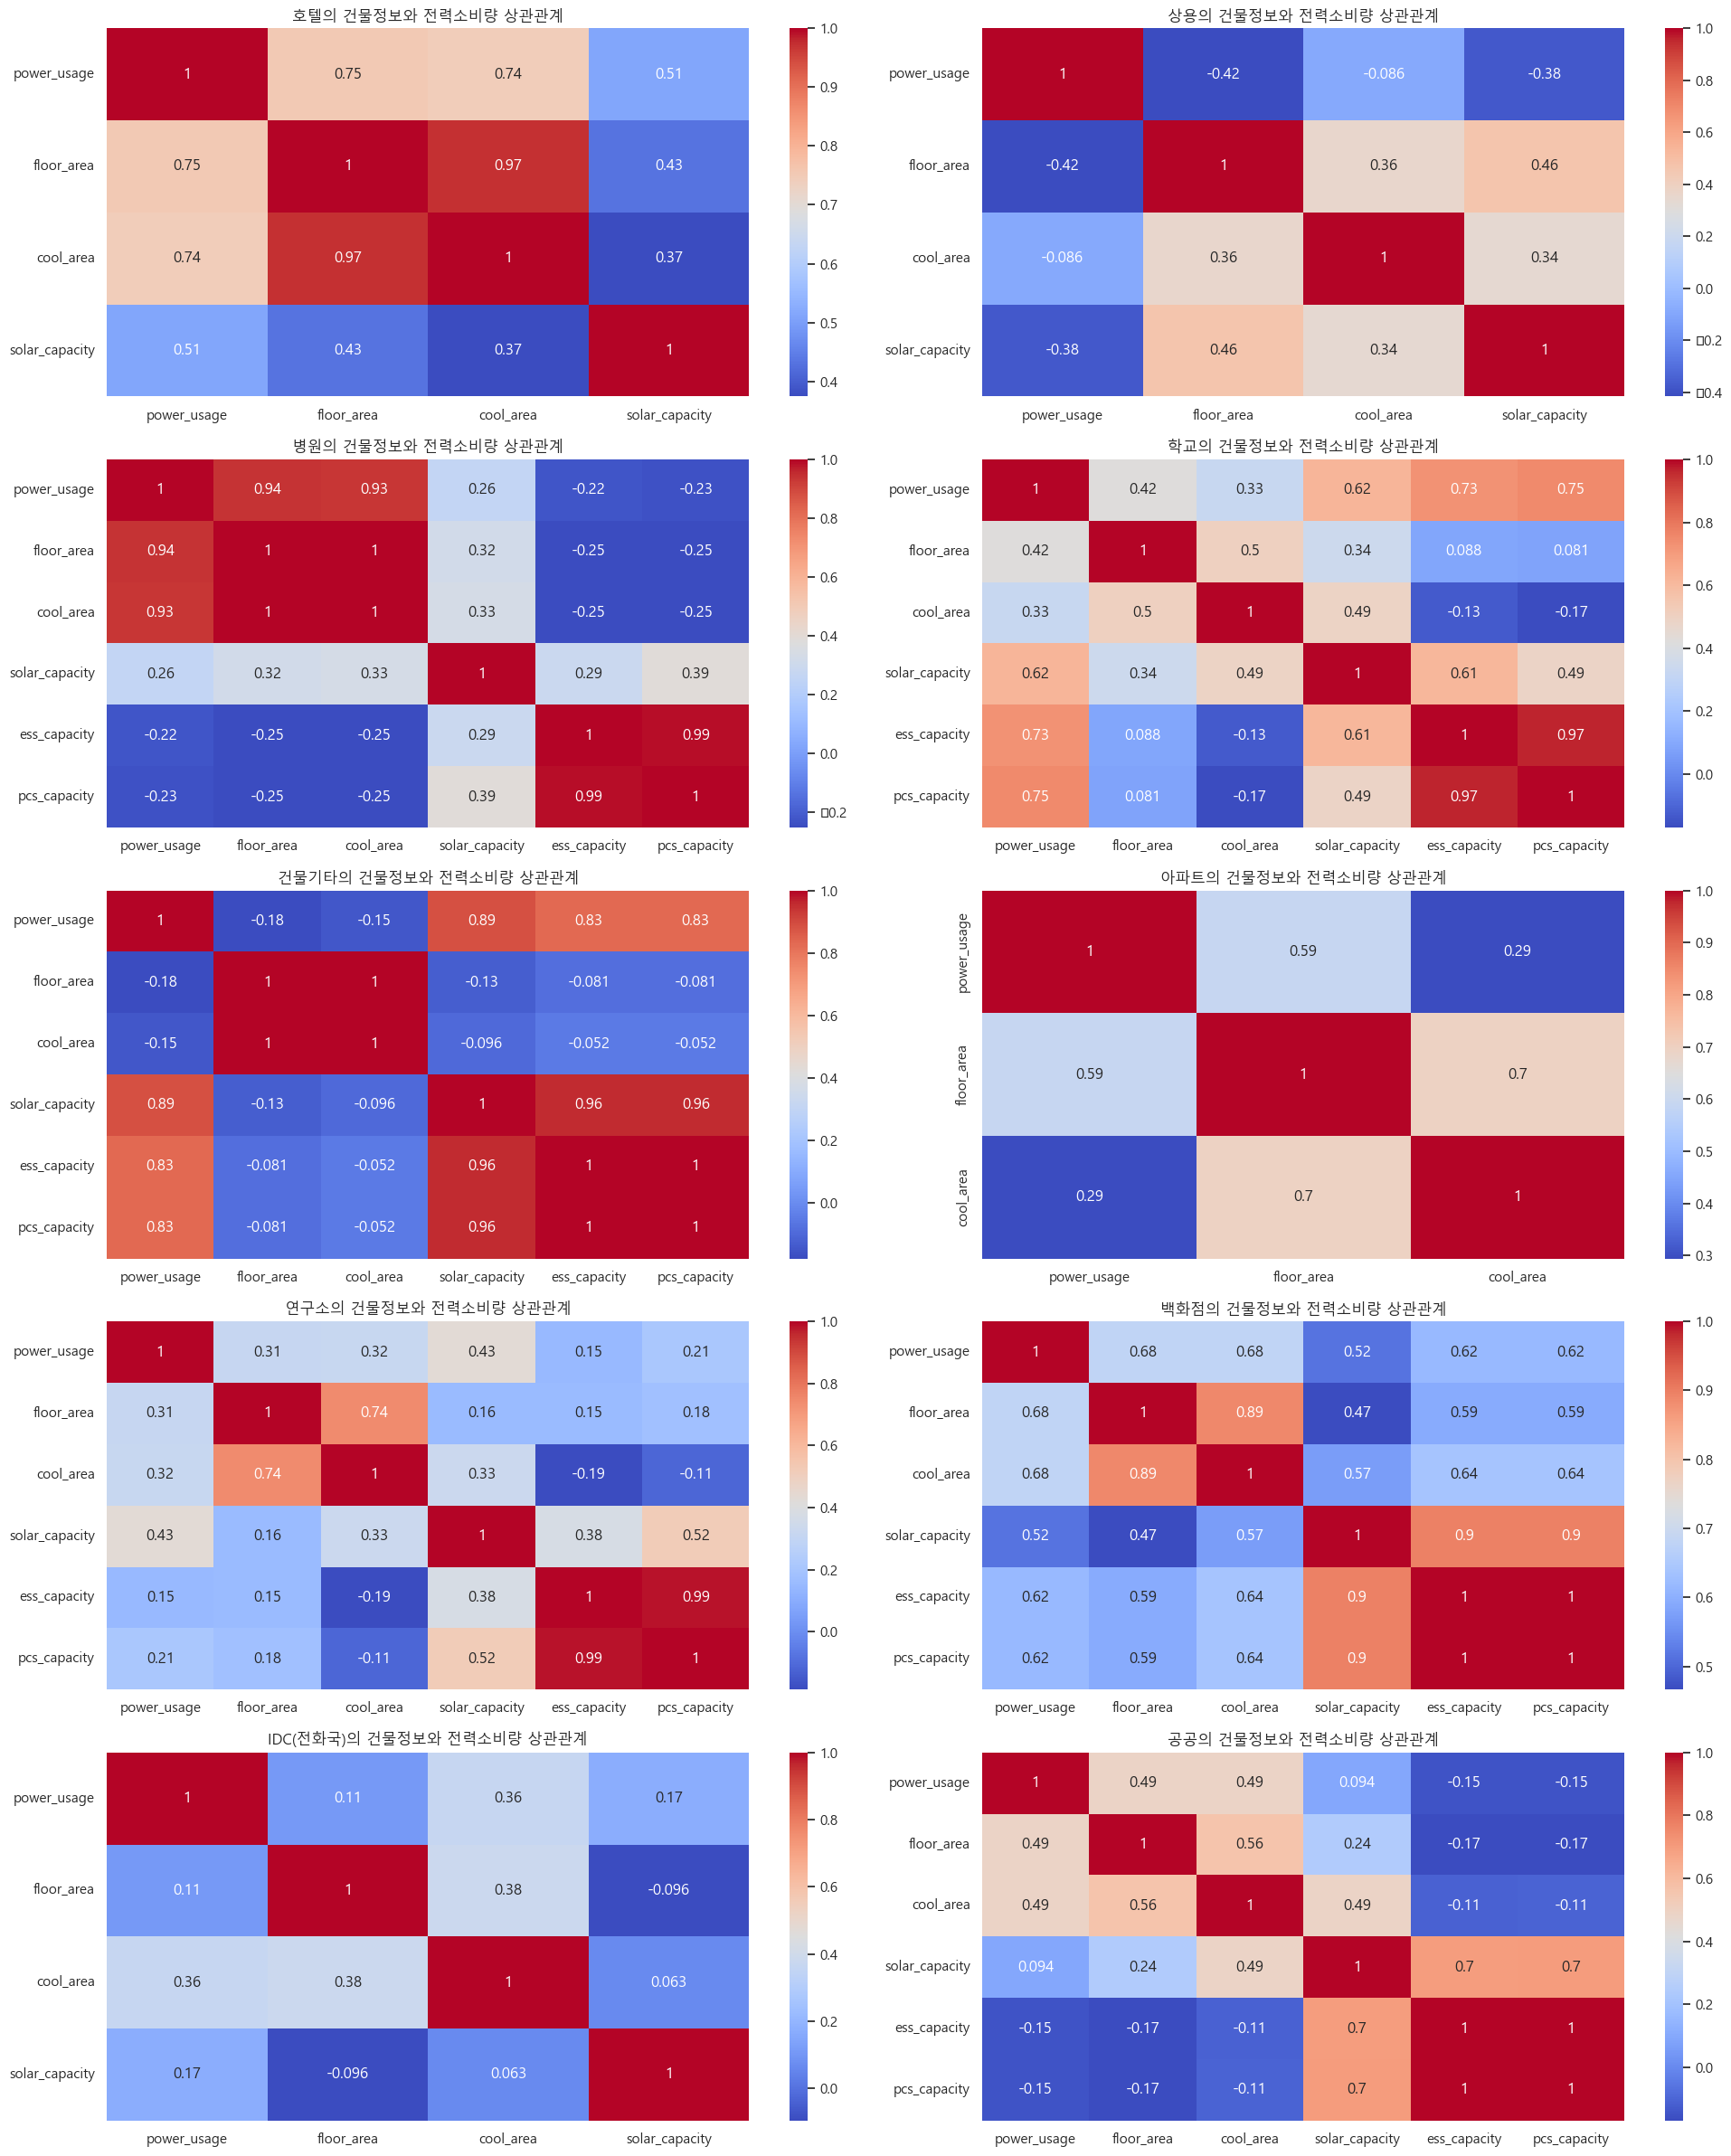

In [86]:
# 주요 건물유형 10개별 상관관계 (5x2 서브플롯) - 개선된 버전
building_types = ['호텔', '상용', '병원', '학교', '건물기타', '아파트', '연구소', '백화점', 'IDC(전화국)', '공공']
fig, axes = plt.subplots(5, 2, figsize=(20, 24))
axes = axes.flatten()

for idx, btype in enumerate(building_types):
    data = train[train['building_type'] == btype]
    
    # 각 건물 유형별 태양광/ESS/PCS 용량의 고유값 확인
    print(f"\n{btype} 건물유형:")
    print(f"  태양광용량 고유값: {sorted(data['solar_capacity'].unique())}")
    print(f"  ESS용량 고유값: {sorted(data['ess_capacity'].unique())}")
    print(f"  PCS용량 고유값: {sorted(data['pcs_capacity'].unique())}")
    
    # 상관관계를 계산할 컬럼들 중에서 분산이 0이 아닌 것들만 선택
    corr_columns = ['power_usage', 'floor_area', 'cool_area', 'solar_capacity', 'ess_capacity', 'pcs_capacity']
    available_columns = []
    
    for col in corr_columns:
        if col in data.columns and data[col].nunique() > 1:  # 고유값이 2개 이상인 경우만
            available_columns.append(col)
    
    print(f"  히트맵에 사용된 컬럼: {available_columns}")
    
    if len(available_columns) >= 2:  # 최소 2개 컬럼이 있어야 상관관계 계산 가능
        corr_matrix = data[available_columns].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[idx])
    else:
        # 상관관계 계산이 불가능한 경우 빈 플롯
        axes[idx].text(0.5, 0.5, '상관관계 계산 불가\n(분산이 0인 컬럼들)', 
                      ha='center', va='center', transform=axes[idx].transAxes)
    
    axes[idx].set_title(f"{btype}의 건물정보와 전력소비량 상관관계")

plt.tight_layout()
plt.show()

- 호텔과 상용 건물, IDC(전화국)은 ESS와 PCS를 사용하지 않는다.
- 호텔은 연면적, 냉방면적과 전력소비량 간 강한 양의 상관관계가 있다. 즉, 큰 호텔일수록 전력소비량이 높다.
- 병원은 연면적, 냉방면적과 전력소비량 간 강한 양의 상관관계가 있다. 즉, 큰 병원일수록 전력소비량이 높다.
- 학교는 태양열, ESS, 그리고 PCS와 전력소비량간 양의 상관관계가 있다.
- 건물기타는 태양열, ESS, 그리고 PCS와 전력소비량 간 강한 양의 상관관계가 있다.
- 아파트는 태양열, ESS, 그리고 PCS를 사용하지 않는다.
- 백화점은 연면적, 냉방면적과 전력소비량 간 양의 상관관계가 있다. 즉, 큰 백화점일수록 전력소비량이 높다.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

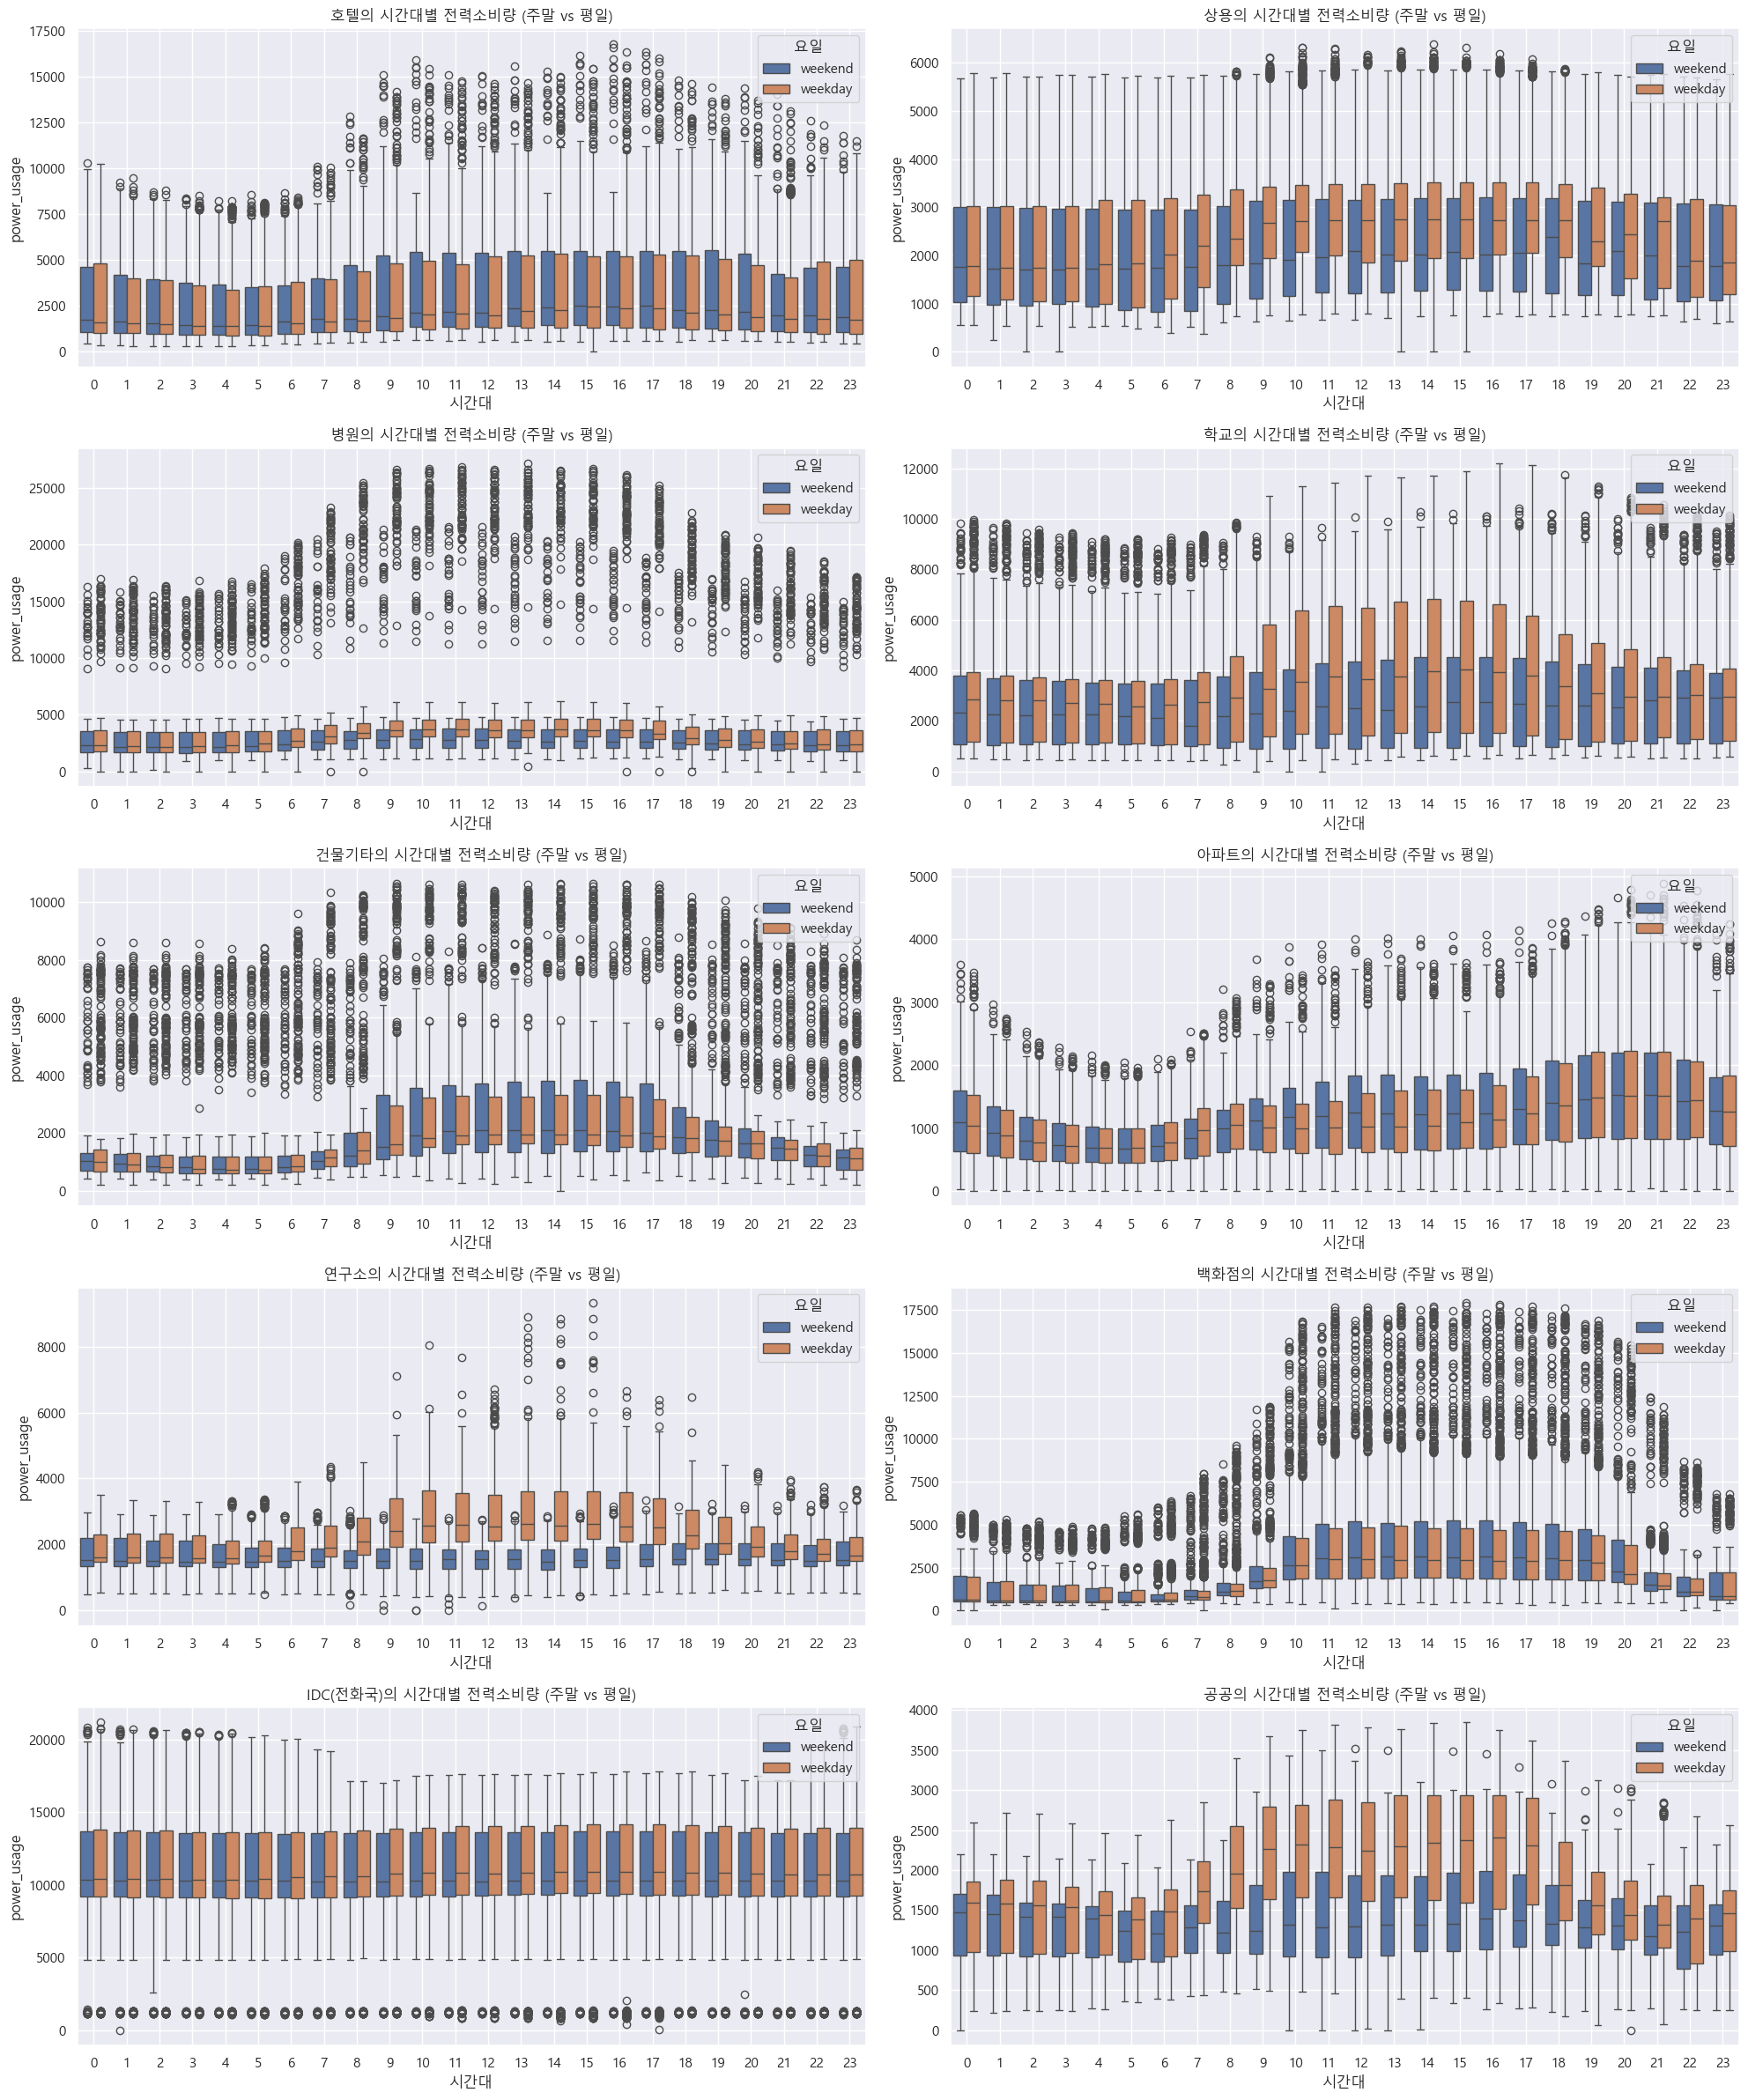

In [87]:
# 주요 건물유형 10개별 시간대별 전력소비량 박스플롯 (5x2 서브플롯)
building_types = ['호텔', '상용', '병원', '학교', '건물기타', '아파트', '연구소', '백화점', 'IDC(전화국)', '공공']
fig, axes = plt.subplots(5, 2, figsize=(20, 24))
axes = axes.flatten()

for idx, btype in enumerate(building_types):
    data = train[train['building_type'] == btype]
    sns.boxplot(data=data, x='hour', y='power_usage', hue='day_type', ax=axes[idx])
    axes[idx].set_title(f"{btype}의 시간대별 전력소비량 (주말 vs 평일)")
    axes[idx].set_xlabel('시간대')
    axes[idx].set_ylabel('power_usage')
    axes[idx].grid(True)
    axes[idx].legend(title='요일', loc='upper right')

plt.tight_layout()
plt.show()

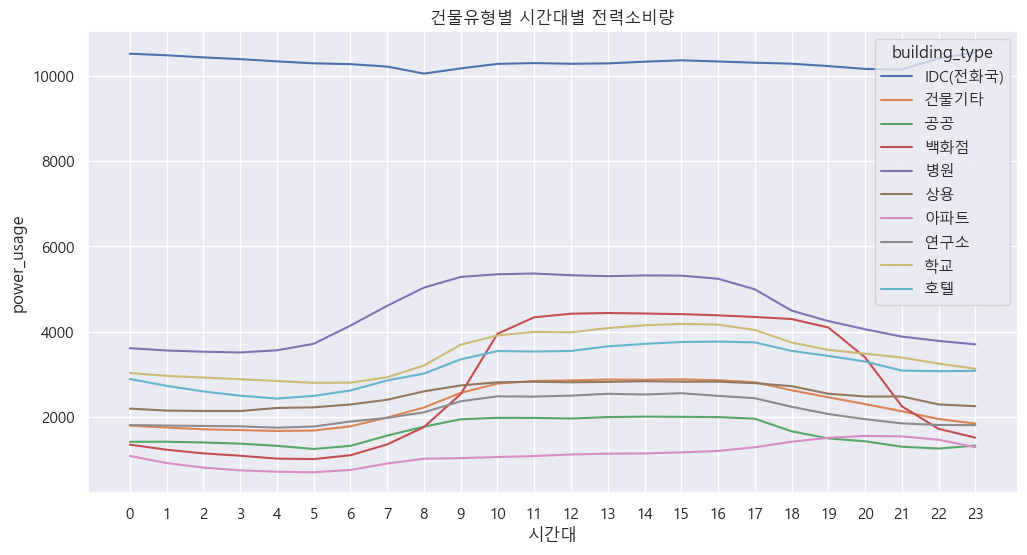

In [88]:
# 시간대별 전력소비 패턴 비교 (building_type별)
# 건물유형별로 시간대(0~23시) 기준 평균 전력소비량 계산
building_type_hourly = train.groupby(['building_type', 'hour'])['power_usage'].mean().reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=building_type_hourly, x='hour', y='power_usage', hue='building_type', ax=ax)
ax.set_title('건물유형별 시간대별 전력소비량')
ax.set_xlabel('시간대')
ax.set_ylabel('power_usage')
plt.xticks(range(0, 24))  # 시간대는 0~23
plt.grid(True)
plt.show()

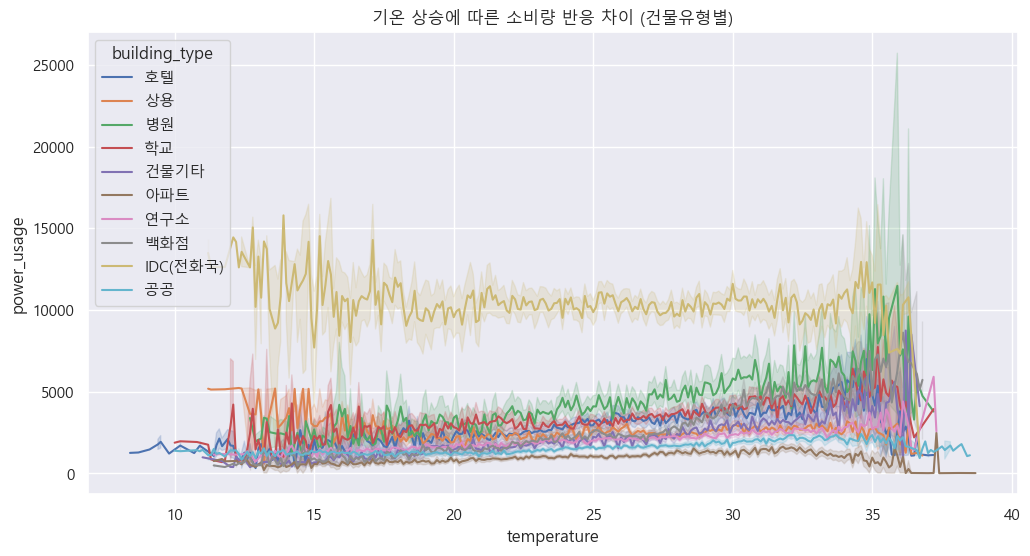

In [89]:
# 기온 상승에 따른 소비량 반응 차이 (건물유형별)
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=train, x='temperature', y='power_usage', hue='building_type', ax=ax)
ax.set_title('기온 상승에 따른 소비량 반응 차이 (건물유형별)')
ax.set_xlabel('temperature')
ax.set_ylabel('power_usage')
plt.grid(True)
plt.show()

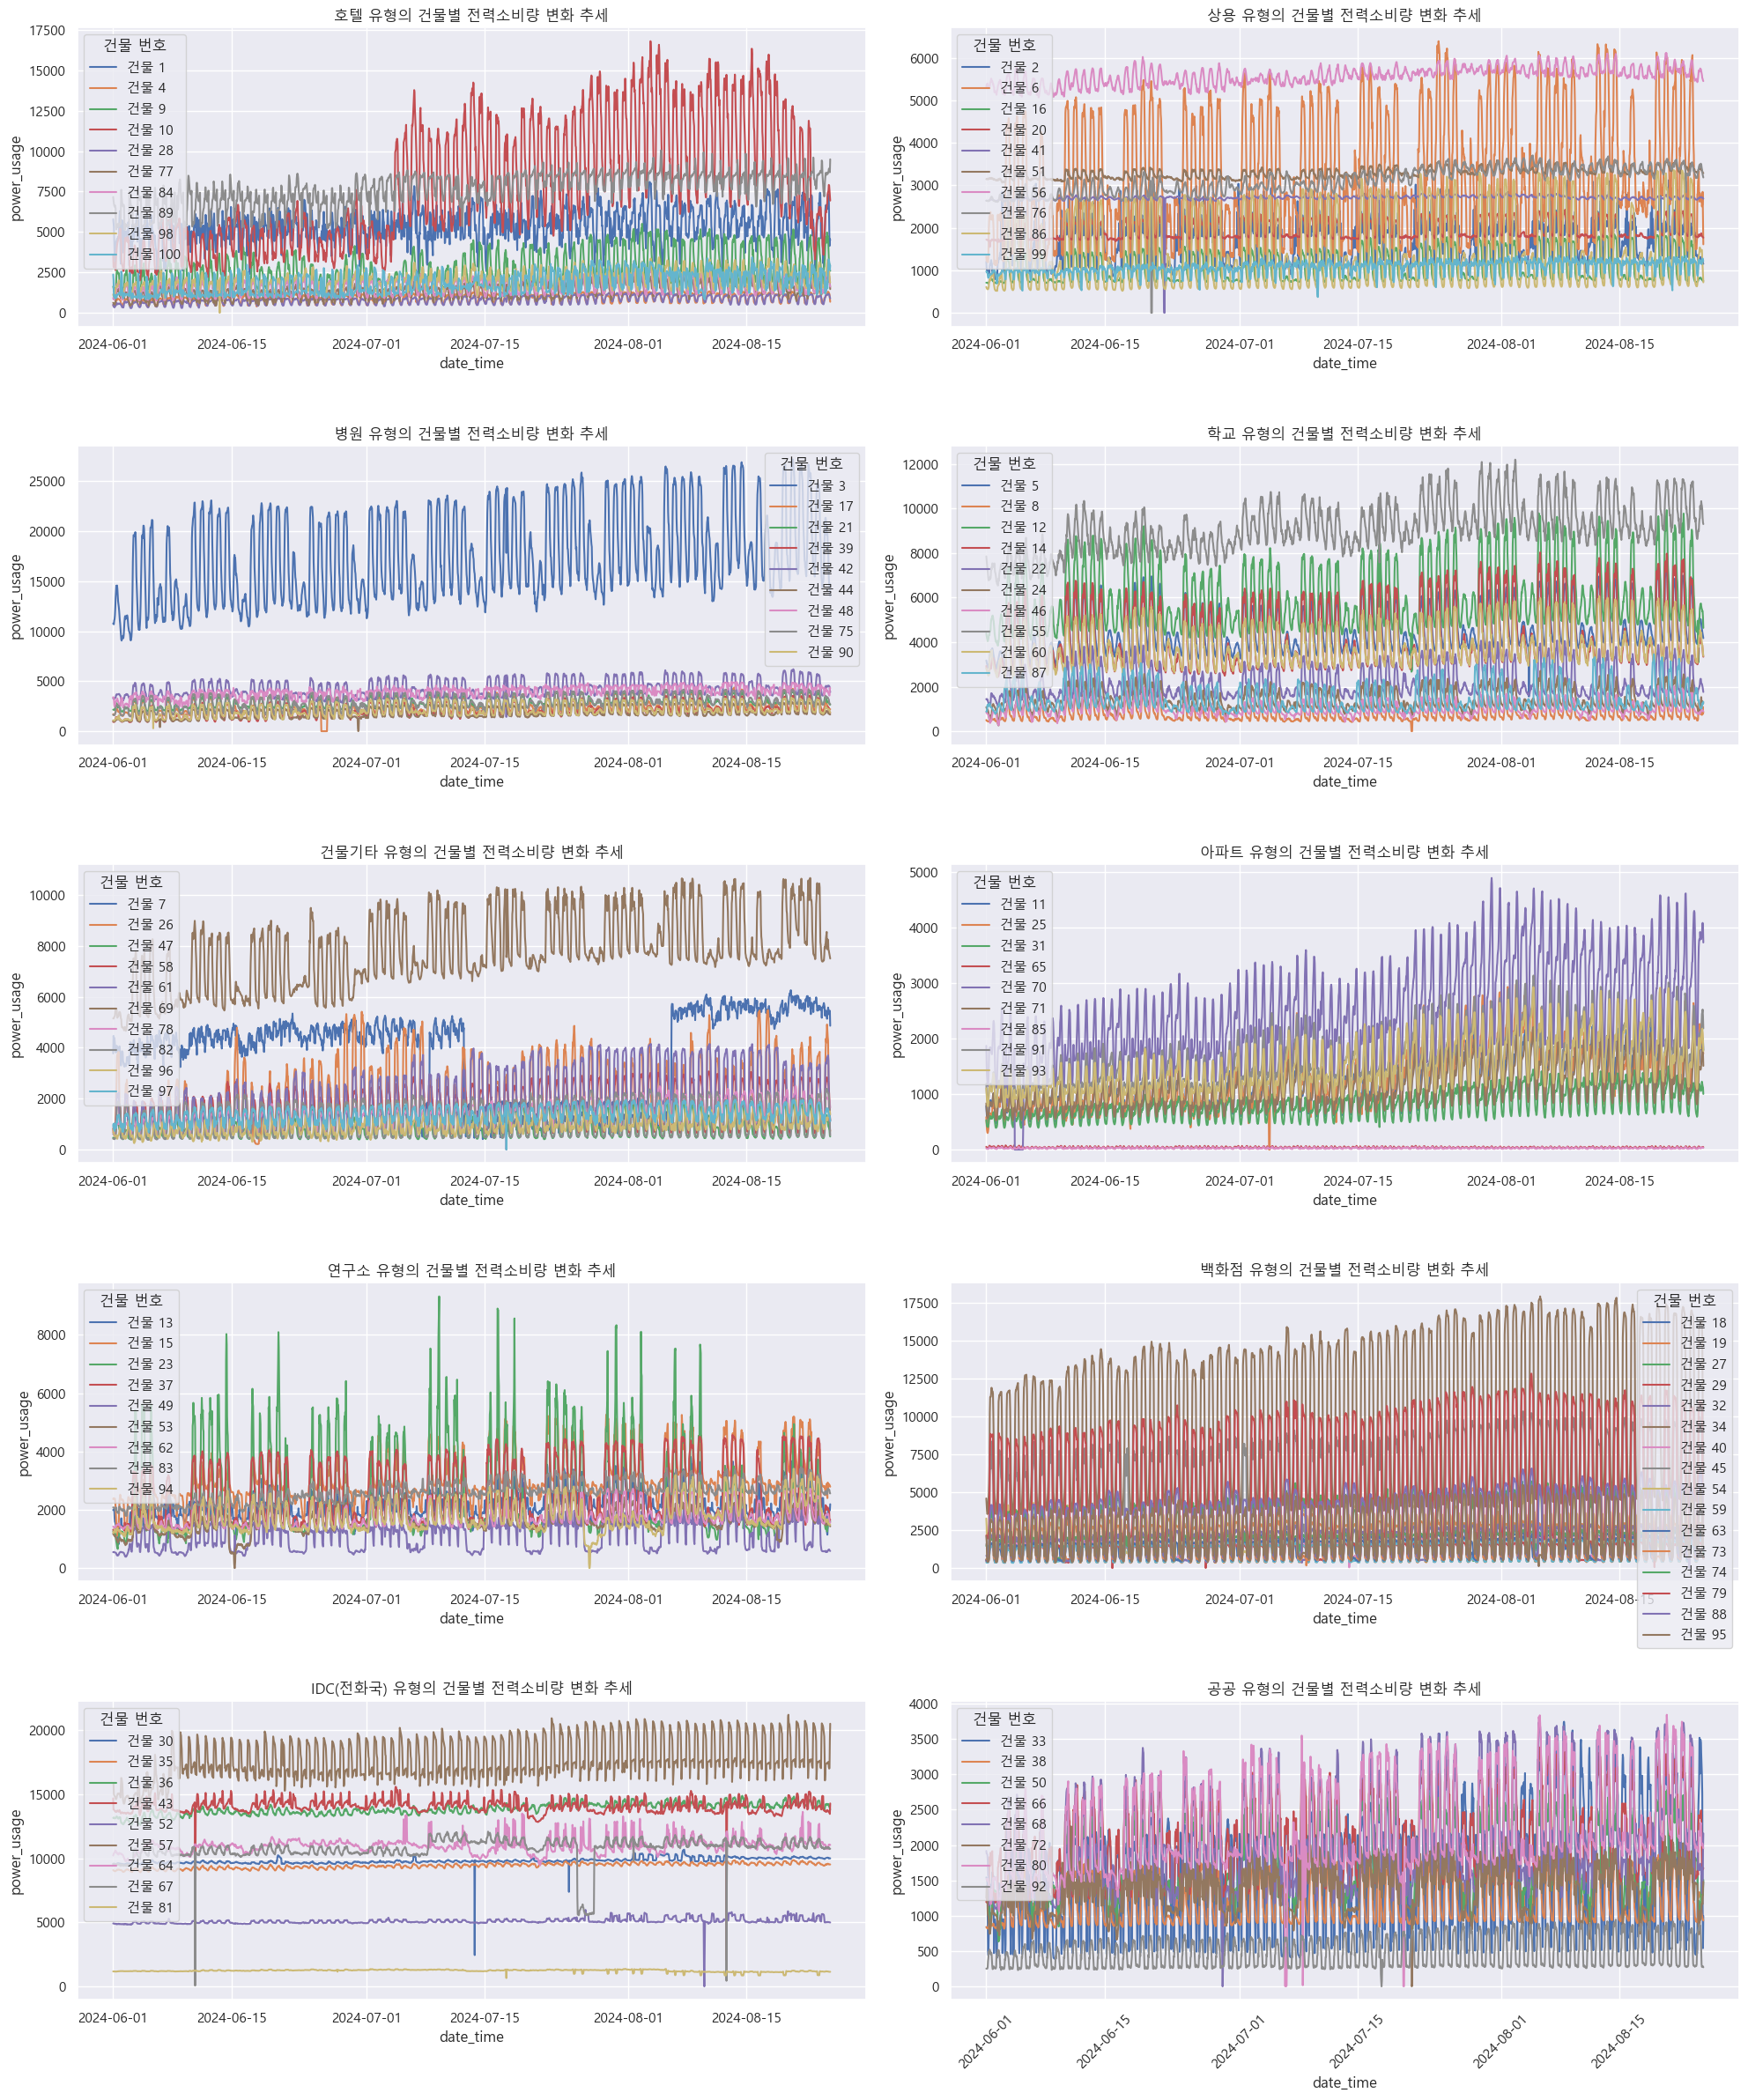

In [90]:
# 주요 건물유형 10개 시간대별 전력소비량 (5x2 서브플롯)     
building_types = ['호텔', '상용', '병원', '학교', '건물기타', '아파트', '연구소', '백화점', 'IDC(전화국)', '공공']
fig, axes = plt.subplots(5, 2, figsize=(20, 24))
axes = axes.flatten()

for idx, btype in enumerate(building_types):
    data = train[train['building_type'] == btype]
    for building_num in data['building_num'].unique():
        building_data = data[data['building_num'] == building_num]
        sns.lineplot(data=building_data, x='date_time', y='power_usage', label=f'건물 {building_num}', ax=axes[idx])

    axes[idx].set_title(f"{btype} 유형의 건물별 전력소비량 변화 추세")
    axes[idx].set_xlabel('date_time')
    axes[idx].set_ylabel('power_usage')
    axes[idx].grid(True)
    axes[idx].legend(title='건물 번호')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

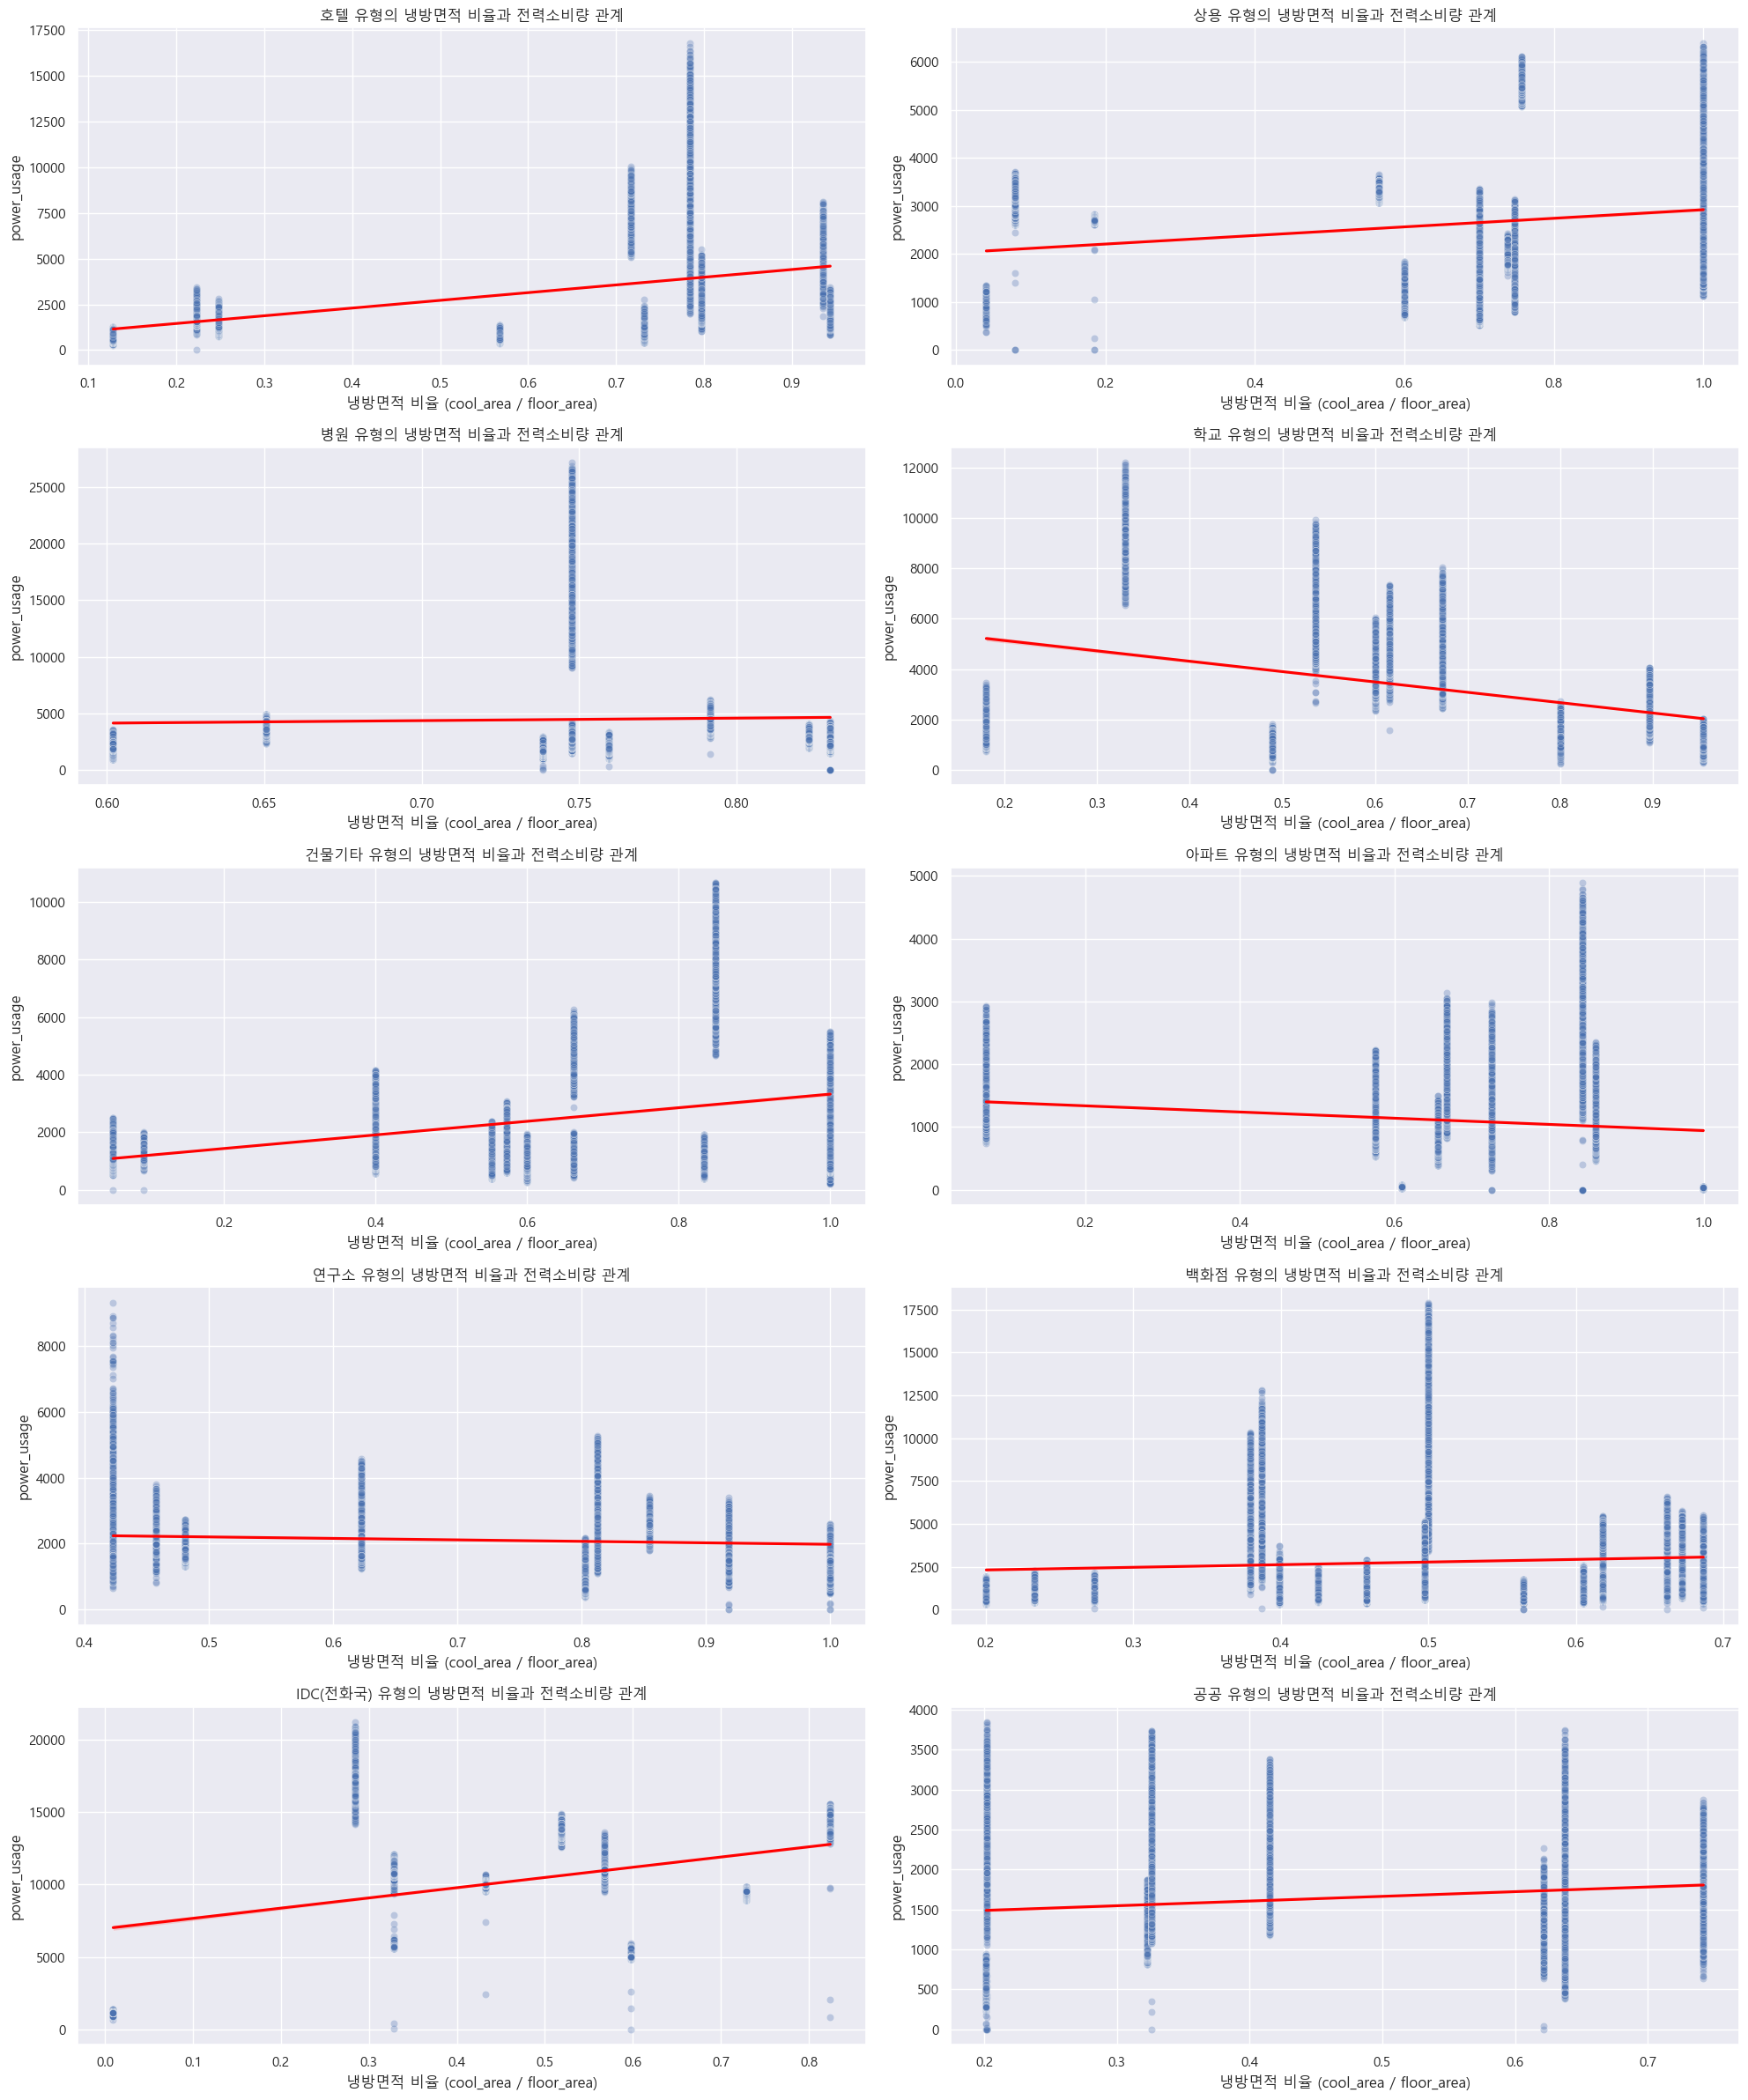

In [91]:
# 건물 크면 전력소비량도 많을까?
# cool_area / floor_area 값이 전력소비량이랑 관계가 있을까?
train['cool_area_ratio'] = train['cool_area'] / train['floor_area']

building_types = ['호텔', '상용', '병원', '학교', '건물기타', '아파트', '연구소', '백화점', 'IDC(전화국)', '공공']
fig, axes = plt.subplots(5, 2, figsize=(20, 24))
axes = axes.flatten()

for idx, btype in enumerate(building_types):
    data = train[train['building_type'] == btype]
    sns.scatterplot(data=data, x='cool_area_ratio', y='power_usage', alpha=0.3, ax=axes[idx])
    sns.regplot(data=data, x='cool_area_ratio', y='power_usage', scatter=False, color='red', ax=axes[idx])
    axes[idx].set_title(f"{btype} 유형의 냉방면적 비율과 전력소비량 관계")
    axes[idx].set_xlabel('냉방면적 비율 (cool_area / floor_area)')
    axes[idx].set_ylabel('power_usage')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

In [25]:
# nums에 해당하는 건물번호만 plot
import pathlib
nums = [1, 15, 20, 23, 24, 30, 41, 43, 48, 49, 50, 52, 64, 67, 72, 76, 77, 80, 81, 87, 89, 100]

building_types = building['building_type'].unique()
for building_type in building_types:
    # 해당 건물유형에서 nums에 포함된 건물번호만 선택
    building_nums_in_type = building[
        (building['building_type'] == building_type) & (building['building_num'].isin(nums))
    ]['building_num'].values
    n_buildings = len(building_nums_in_type)
    if n_buildings == 0:
        continue
    ncols = 3
    nrows = (n_buildings + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)
    axes = axes.flatten()

    for idx, building_num in enumerate (building_nums_in_type):
        temp = train[train['building_num'] == building_num].copy()
        temp['month'] = temp['date_time'].dt.month
        monthly_power_usage = temp.groupby(['month', 'hour'])['power_usage'].mean().reset_index()

        ax = axes[idx]
        sns.lineplot(data=monthly_power_usage, x='hour', y='power_usage', hue='month', palette='tab10', ax=ax, legend='full')
        ax.set_title(f'건물 {building_num}')
        ax.set_xlabel('hour')
        ax.set_ylabel('power_usage')
        ax.legend(title='월')
        ax.grid(True)

    # 범례는 마지막 subplot에만 추가
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[min(n_buildings, len(axes))-1].legend(handles, labels, title='월')

    # 빈 subplot 숨기기
    for j in range(n_buildings, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'{building_type} 유형의 건물별 시간대별 전력소비량 (월별 구분)', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    figures_dir = pathlib.Path(cf.FIGURES_DIR) / building_type
    figures_dir.mkdir(parents=True, exist_ok=True)
    save_path = figures_dir / f'{building_type}_selected_buildings_hourly_power_usage_per_month.png'
    fig.savefig(save_path, bbox_inches='tight')
    plt.close(fig)

In [ ]:
# 각 건물번호의 시간대별 전력소비량을 월별로 구분해서 시각화 및 건물유형별 폴더에 저장

import pathlib

building_nums = train['building_num'].unique()
for building_num in building_nums:
    temp = train[train['building_num'] == building_num].copy()
    temp['month'] = temp['date_time'].dt.month
    monthly_power_usage = temp.groupby(['month', 'hour'])['power_usage'].mean().reset_index()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=monthly_power_usage, x='hour', y='power_usage', hue='month', palette='tab10', ax=ax, legend='full')
    ax.set_title(f'건물 {building_num}의 시간대별 전력소비량 (월별 구분)')
    ax.set_xlabel('hour')
    ax.set_ylabel('power_usage')
    ax.legend(title='월')

    # 건물유형명 추출 및 폴더 생성
    building_type = temp['building_type'].iloc[0]
    figures_dir = pathlib.Path(cf.FIGURES_DIR) / building_type
    figures_dir.mkdir(parents=True, exist_ok=True)
    save_path = figures_dir / f'{building_type}_{building_num}_hourly_power_usage_per_month.png'
    fig.savefig(save_path, bbox_inches='tight')

#### 4. 이상치 탐지

In [93]:
from anomaly import AnomalyDetector
# 이상치 탐지기 인스턴스 생성
anomaly_detector = AnomalyDetector(train)

In [94]:
# 일사량이 0인데, 일조는 있음
train[(train['solar_radiation'] == 0) & (train['sunshine_duration'] > 0)] 

num_date_time  building_num           date_time  temperature  rain  \
16329    9_20240601 09             9 2024-06-01 09:00:00         19.2   0.0   
16330    9_20240601 10             9 2024-06-01 10:00:00         20.6   0.0   
16331    9_20240601 11             9 2024-06-01 11:00:00         21.8   0.0   
16332    9_20240601 12             9 2024-06-01 12:00:00         21.9   0.0   
16333    9_20240601 13             9 2024-06-01 13:00:00         22.9   0.0   
...                ...           ...                 ...          ...   ...   
199911  98_20240824 15            98 2024-08-24 15:00:00         30.2   0.0   
199912  98_20240824 16            98 2024-08-24 16:00:00         30.6   0.0   
199913  98_20240824 17            98 2024-08-24 17:00:00         30.0   0.0   
199914  98_20240824 18            98 2024-08-24 18:00:00         29.1   0.0   
199915  98_20240824 19            98 2024-08-24 19:00:00         27.0   0.0   

        wind  humidity  sunshine_duration  solar_radiation  power_usage  ...  \
16329    1.1      68.0                0.1              0.0      2149.95  ...   
16330    0.8      63.0                0.3              0.0      2528.87  ...   
16331    1.6      60.0                0.6              0.0      2629.98  ...   
16332    1.3      53.0                0.7              0.0      2495.46  ...   
16333    1.7      56.0                0.1              0.0      2480.94  ...   
...      ...       ...                ...              ...          ...  ...   
199911   2.6      64.0                0.9              0.0      3138.84  ...   
199912   1.4      60.0                1.0              0.0      3291.48  ...   
199913   1.5      61.0                0.9              0.0      3263.40  ...   
199914   1.6      64.0                1.0              0.0      2734.56  ...   
199915   1.0      78.0                0.3              0.0      2588.04  ...   

        building_type  floor_area  cool_area solar_capacity  ess_capacity  \
16329              호텔   136757.00   109024.0            0.0           0.0   
16330              호텔   136757.00   109024.0            0.0           0.0   
16331              호텔   136757.00   109024.0            0.0           0.0   
16332              호텔   136757.00   109024.0            0.0           0.0   
16333              호텔   136757.00   109024.0            0.0           0.0   
...               ...         ...        ...            ...           ...   
199911             호텔    99102.62    22097.0            0.0           0.0   
199912             호텔    99102.62    22097.0            0.0           0.0   
199913             호텔    99102.62    22097.0            0.0           0.0   
199914             호텔    99102.62    22097.0            0.0           0.0   
199915             호텔    99102.62    22097.0            0.0           0.0   

       pcs_capacity  has_solar  has_ess  has_pcs  cool_area_ratio  
16329           0.0          0        0        0         0.797210  
16330           0.0          0        0        0         0.797210  
16331           0.0          0        0        0         0.797210  
16332           0.0          0        0        0         0.797210  
16333           0.0          0        0        0         0.797210  
...             ...        ...      ...      ...              ...  
199911          0.0          0        0        0         0.222971  
199912          0.0          0        0        0         0.222971  
199913          0.0          0        0        0         0.222971  
199914          0.0          0        0        0         0.222971  
199915          0.0          0        0        0         0.222971  

[8828 rows x 25 columns]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


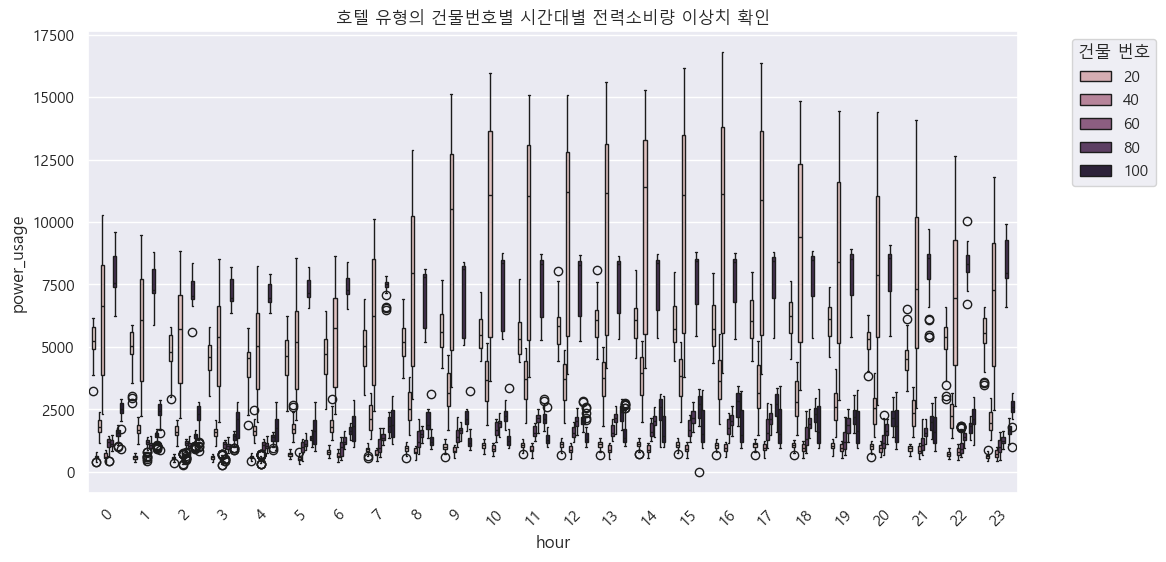

In [95]:
# 건물유형별 건물번호의 시간대별 전력소비량에서 이상치 확인 시각화
building_types = train['building_type'].unique()
for building_type in building_types:
    data = train[train['building_type'] == building_type]
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(data=data, x='hour', y='power_usage', hue='building_num', ax=ax)
    ax.set_title(f'{building_type} 유형의 건물번호별 시간대별 전력소비량 이상치 확인')
    ax.set_xlabel('hour')
    ax.set_ylabel('power_usage')
    ax.legend(title='건물 번호', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)

    break